In [1]:
import numpy as np
import scipy.linalg as la
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib import rcParams
from TurbCurv import orr_sommerfeld
from TurbCurv import orr_sommerfeld_non_uniform, D_matrices_non_uniform
from scipy import integrate
import h5py
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from findiff import FinDiff
from scipy.integrate import cumtrapz
%matplotlib inline
plt.rc('text',usetex=True)
plt.rc('font',family='serif')
rcParams.update({'figure.autolayout': True})

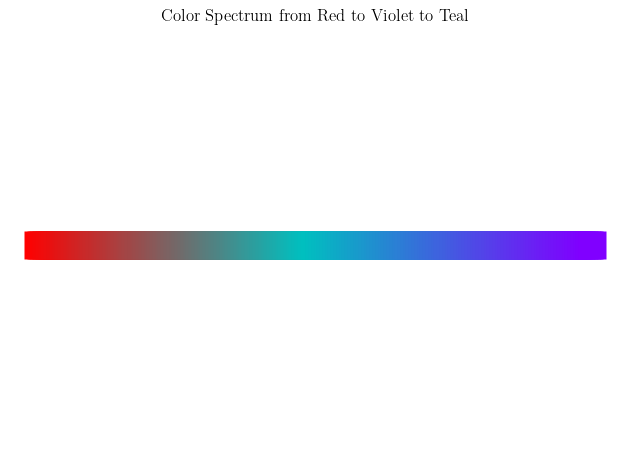

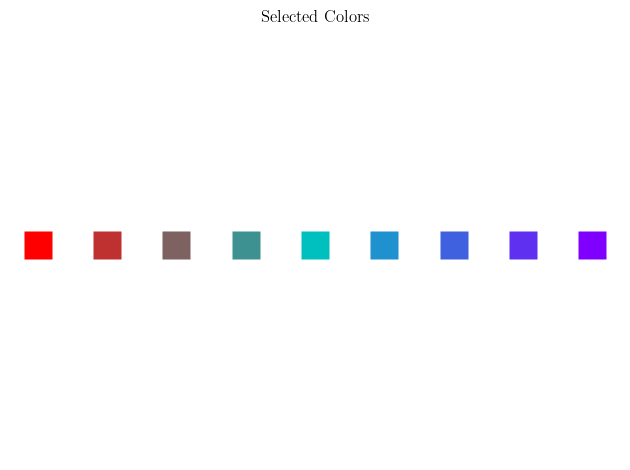

In [2]:
# Define the colors
color1 = np.array([1, 0, 0])  # red
color5 = np.array([0, 0.75, 0.75])  # teal
color9 = np.array([0.5, 0, 1])  # violet

# Number of intermediate colors
num_colors = 100

# Interpolate colors between color1 and color5
colors1_to_5 = np.linspace(color1, color5, num_colors)

# Interpolate colors between color5 and color9
colors5_to_9 = np.linspace(color5, color9, num_colors)

# Combine the colors to form a full spectrum
full_spectrum = np.vstack((colors1_to_5, colors5_to_9))

# Pick 9 colors evenly distributed across the spectrum
indices = np.round(np.linspace(0, full_spectrum.shape[0] - 1, 9)).astype(int)
selected_colors = full_spectrum[indices]

# Store the selected colors in a list
color_array = [list(selected_colors[i]) for i in range(9)]

# Plot the spectrum
plt.figure()
for i in range(full_spectrum.shape[0]):
    plt.plot(i, 1, 's', markersize=20, markeredgecolor='none', markerfacecolor=full_spectrum[i])
plt.axis('off')
plt.title('Color Spectrum from Red to Violet to Teal')
plt.show()

# Display the selected colors
plt.figure()
for i in range(9):
    plt.plot(i, 1, 's', markersize=20, markeredgecolor='none', markerfacecolor=selected_colors[i])
plt.axis('off')
plt.title('Selected Colors')
plt.show()


In [73]:
def mape(y_true, y_pred): 
    """
    Calculate Mean Absolute Percentage Error (MAPE)

    Args:
        y_true (array-like): Actual values
        y_pred (array-like): Predicted values

    Returns:
        float: MAPE value
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [3]:
cd '/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv'

/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv


In [4]:
ls

README.md                  data/
Sullivan2008_test.ipynb    figures/
TurbCurv.py                u_momentum_budget.png
WRLES_apriori_tests.ipynb  w_momentum_budget.png
__pycache__/


In [5]:
filename=['phase_averaged_data_all_10_c-25.mat', 
          'phase_averaged_data_all_09_c-15.mat', 
          'phase_averaged_data_all_08_c-7.mat', 
          'phase_averaged_data_all_07_c-2.mat', 
          'phase_averaged_data_all_06_c0.mat', 
          'phase_averaged_data_all_02_c2.mat', 
          'phase_averaged_data_all_03_c7.mat', 
          'phase_averaged_data_all_04_c15.mat',
          'phase_averaged_data_all_05_c25.mat'];

c_array=[-25,-15,-7,-2,0,2,7,15,25];
num_data=np.size(c_array)
num_data

9

In [6]:
#### Read in profiles from mat files
sully_path='./data/'

class profile_mat_data:
    def __init__(self,Filename):
        DATA=sio.loadmat(Filename)
        zi=1
        Nx=864;
        Ny=576;
        Nz=144;

        self.eta = DATA['eta_phase_avg']
        self.u_w_surf = DATA['u_w_phase_avg'][:,0]-np.mean(DATA['u_w_phase_avg'][:,0],axis=0)
        self.p_w_surf = DATA['p_w_phase_avg'][:,0]-np.mean(DATA['p_w_phase_avg'][:,0],axis=0)
        self.w_surf   = DATA['w_phase_avg'][:,0]-np.mean(DATA['w_phase_avg'][:,0],axis=0)
        
        self.p_w = DATA['p_w_phase_avg'][:,:]-np.mean(DATA['p_w_phase_avg'][:,:],axis=0)
        self.w   = DATA['w_phase_avg'][:,:]-np.mean(DATA['w_phase_avg'][:,:],axis=0)
        self.w_mean   = np.mean(DATA['w_phase_avg'],axis=0)
        
        self.W   = DATA['W_phase_avg'][:,:]-np.mean(DATA['W_phase_avg'][:,:],axis=0)
        self.W_mean   = np.mean(DATA['W_phase_avg'],axis=0)
        
        self.u_w = DATA['u_w_phase_avg'][:,:]-np.mean(DATA['u_w_phase_avg'][:,:],axis=0)
        self.u_mean =  np.mean(DATA['u_w_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.U = DATA['U_phase_avg'][:,:]-np.mean(DATA['U_phase_avg'][:,:],axis=0)
        self.U_mean   = np.mean(DATA['U_phase_avg'],axis=0)
        
        self.zw=DATA['zw']*zi
        
        ##############################################################################################################
        
        self.tau13   = -(DATA['tau13_phase_avg']-np.mean(DATA['tau13_phase_avg'][:,:],axis=0))
        self.tau13_mean   = -np.mean(DATA['tau13_phase_avg'],axis=0)
        
        self.tau13_SGS = (DATA['tau13_SGS_phase_avg']-np.mean(DATA['tau13_SGS_phase_avg'][:,:],axis=0))
        self.tau13_SGS_mean = np.mean(DATA['tau13_SGS_phase_avg'],axis=0)
        
        self.tau13_nu = (DATA['tau13_nu_phase_avg']-np.mean(DATA['tau13_nu_phase_avg'][:,:],axis=0))
        self.tau13_nu_mean  = np.mean(DATA['tau13_nu_phase_avg'],axis=0)

        self.tau13_wave   = -((DATA['tau13_wave_phase_avg']-np.mean(DATA['tau13_wave_phase_avg'][:,:],axis=0)))
        self.tau13_wave_mean   = -np.mean(DATA['tau13_wave_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.tau31   = -(DATA['tau31_phase_avg']-np.mean(DATA['tau31_phase_avg'][:,:],axis=0))
        self.tau31_mean   = -np.mean(DATA['tau31_phase_avg'],axis=0)
        
        self.tau31_SGS = (DATA['tau31_SGS_phase_avg']-np.mean(DATA['tau31_SGS_phase_avg'][:,:],axis=0))
        self.tau31_SGS_mean = np.mean(DATA['tau31_SGS_phase_avg'],axis=0)
        
        self.tau31_nu = (DATA['tau31_nu_phase_avg']-np.mean(DATA['tau31_nu_phase_avg'][:,:],axis=0))
        self.tau31_nu_mean  = np.mean(DATA['tau31_nu_phase_avg'],axis=0)

        self.tau31_wave   = -(DATA['tau31_wave_phase_avg']-np.mean(DATA['tau31_wave_phase_avg'][:,:],axis=0))
        self.tau31_wave_mean   = -np.mean(DATA['tau31_wave_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.tau11   = -(DATA['tau11_phase_avg']-np.mean(DATA['tau11_phase_avg'][:,:],axis=0))
        self.tau11_mean   = -np.mean(DATA['tau11_phase_avg'],axis=0)
        
        self.tau11_SGS = (DATA['tau11_SGS_phase_avg']-np.mean(DATA['tau11_SGS_phase_avg'][:,:],axis=0))
        self.tau11_SGS_mean = np.mean(DATA['tau11_SGS_phase_avg'],axis=0)
        
        self.tau11_nu = (DATA['tau11_nu_phase_avg']-np.mean(DATA['tau11_nu_phase_avg'][:,:],axis=0))
        self.tau11_nu_mean = np.mean(DATA['tau11_nu_phase_avg'],axis=0)
        
        self.tau11_wave   = -(DATA['tau11_wave_phase_avg']-np.mean(DATA['tau11_wave_phase_avg'][:,:],axis=0))
        self.tau11_wave_mean   = -np.mean(DATA['tau11_wave_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.tau33  = -(DATA['tau33_phase_avg']-np.mean(DATA['tau33_phase_avg'][:,:],axis=0))
        self.tau33_mean = -np.mean(DATA['tau33_phase_avg'],axis=0)
        
        self.tau33_SGS = (DATA['tau33_SGS_phase_avg']-np.mean(DATA['tau33_SGS_phase_avg'][:,:],axis=0))
        self.tau33_SGS_mean = np.mean(DATA['tau33_SGS_phase_avg'],axis=0)
        
        self.tau33_nu = (DATA['tau33_nu_phase_avg']-np.mean(DATA['tau33_nu_phase_avg'][:,:],axis=0))
        self.tau33_nu_mean = np.mean(DATA['tau33_nu_phase_avg'],axis=0)
        
        self.tau33_wave  = -(DATA['tau33_wave_phase_avg']-np.mean(DATA['tau33_wave_phase_avg'][:,:],axis=0))
        self.tau33_wave_mean = -np.mean(DATA['tau33_wave_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.tau11_d = self.tau11 - (1/3)*(self.tau11+self.tau33)
        self.tau33_d = self.tau33 - (1/3)*(self.tau11+self.tau33)
        self.tau11_d_SGS  = self.tau11_SGS  - (1/3)*(self.tau11_SGS  + self.tau33_SGS)
        self.tau33_d_SGS  = self.tau33_SGS  - (1/3)*(self.tau11_SGS  + self.tau33_SGS)
        self.tau11_d_wave = self.tau11_wave - (1/3)*(self.tau11_wave + self.tau33_wave)
        self.tau33_d_wave = self.tau33_wave - (1/3)*(self.tau11_wave + self.tau33_wave)
        self.tau11_d_nu  = self.tau11_nu  - (1/3)*(self.tau11_nu  + self.tau33_nu)
        self.tau33_d_nu  = self.tau33_nu  - (1/3)*(self.tau11_nu  + self.tau33_nu)
        
        ##############################################################################################################
        
        self.taup_13 = -(DATA['taup_13_phase_avg']-np.mean(DATA['taup_13_phase_avg'][:,:],axis=0))
        self.taup_13_mean = -np.mean(DATA['taup_13_phase_avg'],axis=0)
        
        self.taup_11 = -(DATA['taup_11_phase_avg']-np.mean(DATA['taup_11_phase_avg'][:,:],axis=0))
        self.taup_11_mean = -np.mean(DATA['taup_11_phase_avg'],axis=0)
        
        ##############################################################################################################
        
#         tau13_wave_xz = np.zeros([Nx, Nz], dtype='float64')
#         for k in range(Nz):
#             tau13_wave_xz[:, k] = -(
#                 DATA['u_w_phase_avg'][:, k] - np.mean(DATA['u_w_phase_avg'][:, k], axis=0)
#             ) * (
#                 DATA['W_phase_avg'][:, k] - np.mean(DATA['W_phase_avg'][:, k], axis=0)
#             )

#         self.tau13_wave = np.mean(tau13_wave_xz[:,:],axis=0)
#         self.tau13_wave_contour = tau13_wave_xz[:,:]
        
        ##############################################################################################################
        
        
        self.tau_tot  = self.tau13+self.tau13_SGS+self.tau13_nu+self.taup_13+self.tau13_wave
        self.tau_tot_mean  = self.tau13_mean+self.tau13_SGS_mean+self.tau13_nu_mean+self.taup_13_mean+self.tau13_wave_mean
        
LES_data =[[],[],[],[],[],[],[],[],[]]
for n in range(num_data):
    LES_data[n]=profile_mat_data(sully_path+filename[n])
    print(LES_data[n])


In [7]:
# Problem Parameters
N = 1024*2
ak=0.1
k_wavno=4
k=4
a=ak/k# in meters 
Retau=1000
nu=1/Retau
ustar=1
kappa=0.41;

pex=0.25;
pey=0.5;
pez=1;
Lx=2*np.pi/pex;
Ly=2*np.pi/pey;
Lz=1;
zi=Lz;
Hbar=Lz;

Nx=864;
Ny=576;
Nz=144;
x_LES=np.linspace(0,Lx,Nx)
kx=np.fft.fftfreq(Nx,d = 1/(Nx*pex))

use_non_uniform_grid=1;
#Tanh-stretched grid
z_min = 1e-6  # Minimum value in the physical domain
z_max = 1.0  # Maximum value in the physical domain
alpha = 5.0  # Stretching factor (adjust for more/less stretching)

# Create a linearly spaced grid in the range [0, 1]
eta = np.linspace(-1, 1, N)

# Apply the tanh stretching
z_stretched = 0.5 * (np.tanh(alpha * eta) + 1)

# Map the stretched grid to the desired physical domain
z_non_uniform = z_min + z_stretched * (z_max - z_min)
#z_non_uniform = np.logspace(np.log10(1e-6),np.log10(zi), N)

#Uniform grid
z_uniform = np.linspace(0,zi, N)


/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1299: RuntimeWarning: divide by zero encountered in scalar divide
  b = - (dx2 + dx1) / (dx1 * dx2)
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1300: RuntimeWarning: divide by zero encountered in scalar divide
  c = (2. * dx2 + dx1) / (dx2 * (dx1 + dx2))
/Users/

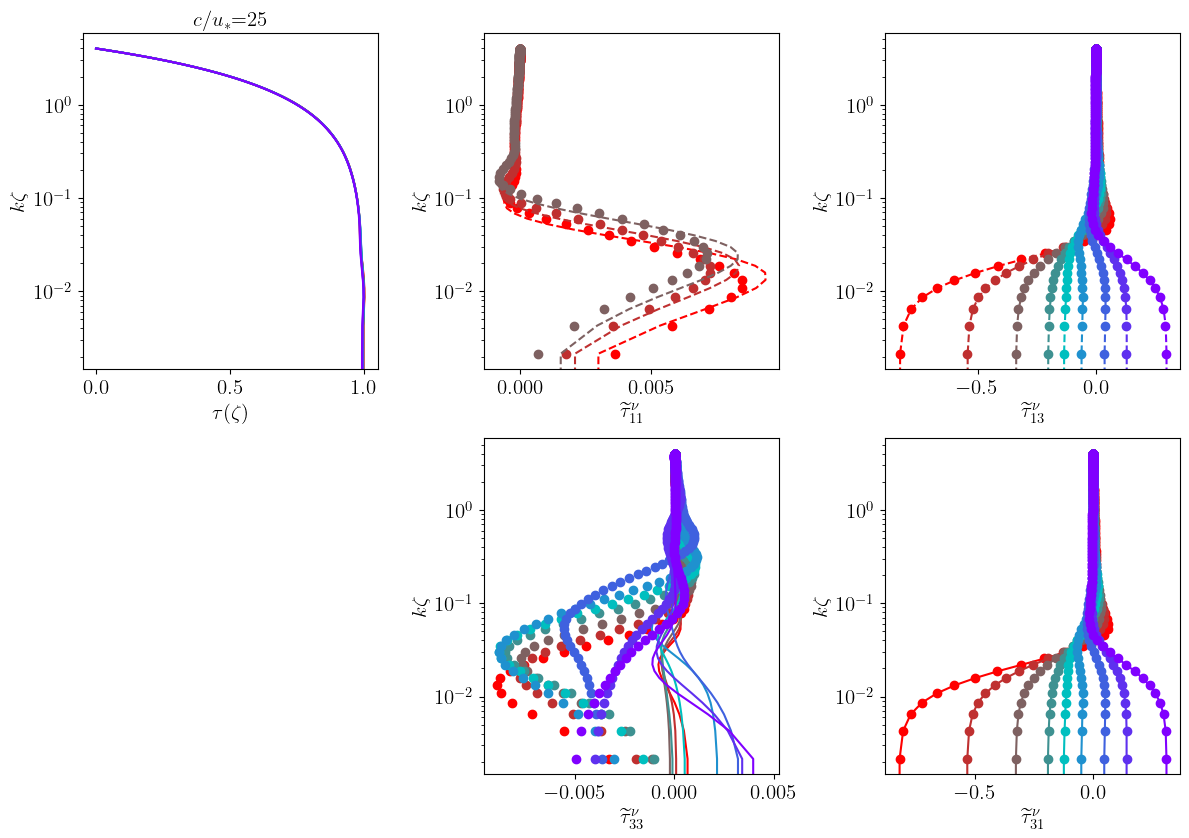

In [8]:
#Visualize vertical profile of viscous stress's Fourier coefficients
plt.figure(18,figsize=(12,12))
ax1=plt.subplot(331)
for num_data_select in range(9):
    plt.semilogy(+LES_data[num_data_select].tau13_nu_mean*(-1) \
                +LES_data[num_data_select].taup_13_mean*(-1) \
                +LES_data[num_data_select].tau13_mean*(-1)+ \
                +LES_data[num_data_select].tau13_wave_mean*(-1) \
                +LES_data[num_data_select].tau13_SGS_mean*(-1) \
                ,k_wavno*LES_data[num_data_select].zw,color=color_array[num_data_select],linestyle='-')
   
ax1.set_xlabel(r'$\tau(\zeta)$',fontsize=15)
ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
ax1.set_ylabel(r'$k\zeta$',fontsize=15)
ax1.tick_params(labelsize=15)


ax1=plt.subplot(332)
for num_data_select in range(3):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)
    
    tau11_nu_hat= np.fft.fft(LES_data[num_data_select].tau11_nu,axis=0,norm='forward')
    w_hat = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    dwhatdz =np.gradient(w_hat[16,:],LES_data[num_data_select].zw.flatten(),edge_order=2)
    plt.semilogy(tau11_nu_hat[16,:] \
                 ,k_wavno*LES_data[num_data_select].zw,color=color_array[num_data_select],linestyle='--')
    
    plt.semilogy(2*nu*dwhatdz \
                 ,k_wavno*LES_data[num_data_select].zw,color=color_array[num_data_select],marker='o',linestyle='none')
    

ax1.set_xlabel(r'$\widetilde{\tau}^\nu_{11}$',fontsize=15)
ax1.set_ylabel(r'$k\zeta$',fontsize=15)
ax1.tick_params(labelsize=15)

ax1=plt.subplot(333)
for num_data_select in range(9):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)
    
    tau13_nu_hat_LES= np.fft.fft(LES_data[num_data_select].tau13_nu,axis=0,norm='forward')
    
    w_hat = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    u_hat = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    duhatdz = np.gradient(u_hat[16,:],z_data,edge_order=2)
    dwhatdz =np.gradient(w_hat[16,:],z_data,edge_order=2)
    
    tau13_nu_hat_LES2=-nu*(duhatdz+1j*k_wavno*w_hat[16,:])-nu*U_prime_LES*(1/zi)*(a/2)
    
    
    plt.semilogy(tau13_nu_hat_LES[16,:] \
                 ,k_wavno*z_data,color=color_array[num_data_select],linestyle='--')
    
    plt.semilogy( tau13_nu_hat_LES2\
                 ,k_wavno*z_data,color=color_array[num_data_select],marker='o',linestyle='none')
    

ax1.set_xlabel(r'$\widetilde{\tau}^\nu_{13}$',fontsize=15)
ax1.set_ylabel(r'$k\zeta$',fontsize=15)
ax1.tick_params(labelsize=15)


ax1=plt.subplot(335)
for num_data_select in range(9):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)
    
    tau33_nu_hat_LES= np.fft.fft(LES_data[num_data_select].tau33_nu,axis=0,norm='forward')
    
    w_hat = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    u_hat = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    duhatdz = np.gradient(u_hat[16,:],z_data,edge_order=2)
    dwhatdz =np.gradient(w_hat[16,:],z_data,edge_order=2)
    
    tau33_nu_hat_LES2=nu*(1j*k_wavno*u_hat[16,:]-dwhatdz)
    
    
    plt.semilogy(tau33_nu_hat_LES[16,:] \
                 ,k_wavno*z_data,color=color_array[num_data_select],linestyle='-')
    
    plt.semilogy( tau33_nu_hat_LES2\
                 ,k_wavno*z_data,color=color_array[num_data_select],marker='o',linestyle='none')
    

ax1.set_xlabel(r'$\widetilde{\tau}^\nu_{33}$',fontsize=15)
ax1.set_ylabel(r'$k\zeta$',fontsize=15)
ax1.tick_params(labelsize=15)


ax1=plt.subplot(336)
for num_data_select in range(9):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)
    
    tau31_nu_hat_LES= np.fft.fft(LES_data[num_data_select].tau31_nu,axis=0,norm='forward')
    
    w_hat = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    u_hat = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    duhatdz = np.gradient(u_hat[16,:],z_data,edge_order=2)
    dwhatdz =np.gradient(w_hat[16,:],z_data,edge_order=2)
    
    tau31_nu_hat_LES2=-nu*(duhatdz+1j*k_wavno*w_hat[16,:])
    
    
    plt.semilogy(tau31_nu_hat_LES[16,:] \
                 ,k_wavno*z_data,color=color_array[num_data_select],linestyle='-')
    
    plt.semilogy( tau31_nu_hat_LES2\
                 ,k_wavno*z_data,color=color_array[num_data_select],marker='o',linestyle='none')
    

ax1.set_xlabel(r'$\widetilde{\tau}^\nu_{31}$',fontsize=15)
ax1.set_ylabel(r'$k\zeta$',fontsize=15)
ax1.tick_params(labelsize=15)

plt.show()

\begin{align*}
    (\langle u \rangle-c)\frac{\partial \tilde{u}}{\partial \xi}+(\tilde{w}+(\langle u \rangle-c)g\tilde{\eta}_\xi)\frac{\partial\langle u \rangle}{\partial\zeta}+\frac{\partial\tilde{p}}{\partial\xi}&=\nu\left(\frac{\partial^2\tilde{u}}{\partial \zeta^2}-\frac{\partial^2\tilde{w}}{\partial \xi\partial \zeta}\right)+\nu\frac{\partial}{\partial\zeta}\left(g_\zeta\frac{\partial\langle u \rangle}{\partial \zeta}\right)\tilde{\eta}-\frac{\partial \tilde{\tau}_{1m}}{\partial \xi_m}-\frac{\partial \tilde{\tau}^w_{1m}}{\partial \xi_m}
\end{align*}

\begin{align*}
    \underbrace{(\langle u \rangle-c)\mathrm{i}k\hat{u}+(\hat{w}+(\langle u \rangle-c)g\mathrm{i}k\hat{\eta})\frac{\partial\langle u \rangle}{\partial\zeta}}_{Adv}+\underbrace{\mathrm{i}k\hat{p}}_{Pre}&=\underbrace{\nu\left(\frac{\partial^2\hat{u}}{\partial \zeta^2}-\mathrm{i}k\frac{\partial\hat{w}}{\partial \zeta}\right)+\nu\frac{\partial}{\partial\zeta}\left(g_\zeta\frac{\partial\langle u \rangle}{\partial \zeta}\right)\hat{\eta}}_{Visc}-\underbrace{\mathrm{i}k\hat{\tau}_{11}-\frac{\partial \hat{\tau}_{13}}{\partial \zeta}}_{Turb}-\underbrace{\mathrm{i}k \hat{\tau}^w_{11}-\frac{\partial \hat{\tau}^w_{13}}{\partial \zeta}}_{Wave}
\end{align*}

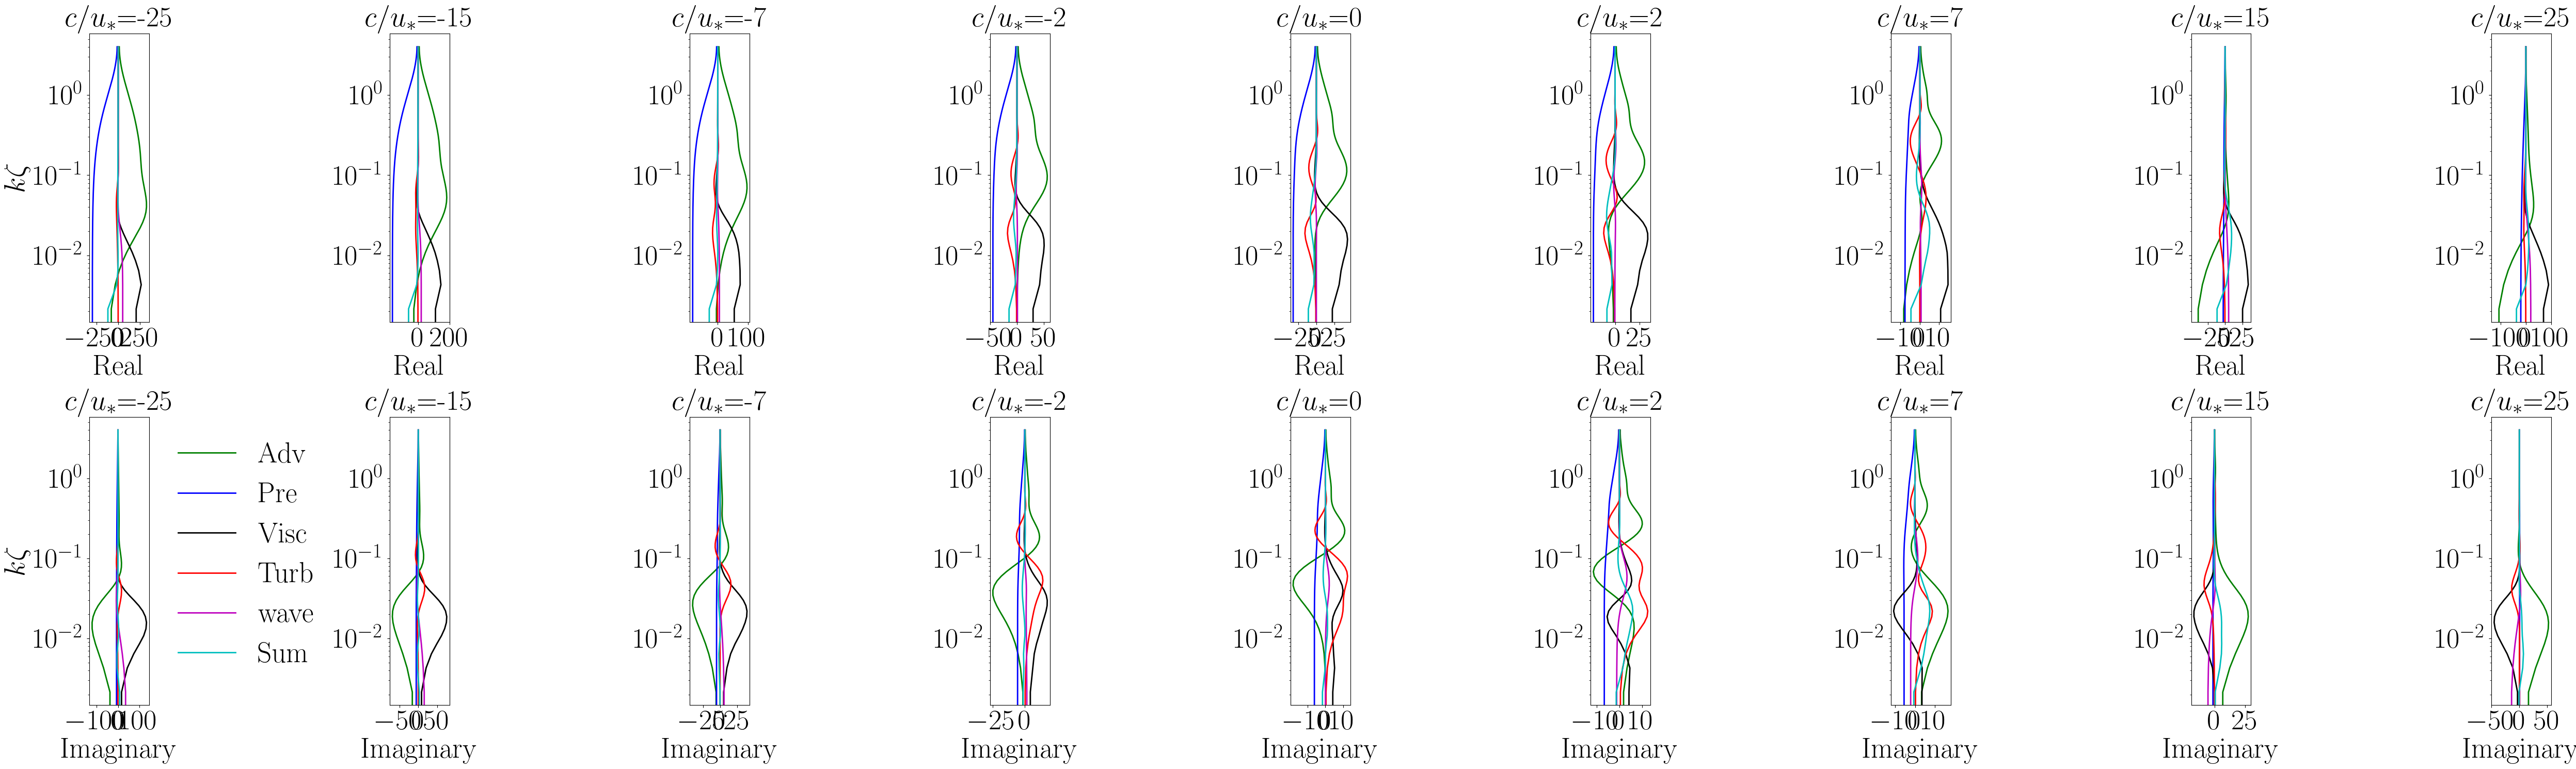

In [113]:
#u-momentum term by term balance
plt.figure(18,figsize=(50,15))
font_size=40;
counter=1;
for num_data_select in range(9):
    
    z_data = np.asarray(LES_data[num_data_select].zw).flatten()
    U_data = np.asarray(LES_data[num_data_select].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)
    
    w_hat_LES= np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    dwhatdz=np.gradient(w_hat_LES[16,:],z_data,edge_order=2)
    d2whatdz2=np.gradient(dwhatdz,z_data,edge_order=2)
    
    u_hat_LES= np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    duhatdz=np.gradient(u_hat_LES[16,:],z_data,edge_order=2)
    d2uhatdz2=np.gradient(duhatdz,z_data,edge_order=2)
    
    tau11_nu_hat_LES= np.fft.fft(LES_data[num_data_select].tau11_nu,axis=0,norm='forward')
    
    tau13_nu_hat_LES= np.fft.fft(LES_data[num_data_select].tau13_nu,axis=0,norm='forward')
    dtau13_nu_dzeta = np.gradient(tau13_nu_hat_LES[16,:],z_data,edge_order=2)
    
    tau11_hat_LES = np.fft.fft(LES_data[num_data_select].tau11+LES_data[num_data_select].tau11_SGS,axis=0,norm='forward')
    tau13_hat_LES = np.fft.fft(LES_data[num_data_select].tau13+LES_data[num_data_select].tau13_SGS,axis=0,norm='forward')
    dtau13_dzeta = np.gradient(tau13_hat_LES[16,:],z_data,edge_order=2)
    
    tau11_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau11_wave,axis=0,norm='forward')
    tau13_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau13_wave,axis=0,norm='forward')
    dtau13_wave_dzeta = np.gradient(tau13_wave_hat_LES[16,:],z_data,edge_order=2)
    
    p_hat_LES= np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    dphatdz=np.gradient(p_hat_LES[16,:],z_data,edge_order=2)
    
    
    adv_term=(U_data-c_array[num_data_select])*1j*k_wavno*u_hat_LES[16,:] \
             + (w_hat_LES[16,:]+(U_data-c_array[num_data_select])*(z_data/zi-1)*1j*k_wavno*(a/2))*U_prime_LES 
    
    dpdz_term=1j*k_wavno*p_hat_LES[16,:]
    #visc_term=-nu*(-k_wavno**2*w_hat_LES[16,:]+d2whatdz2)#1j*k_wavno*tau31_nu_hat_LES[16,:]+dtau33_nu_dzeta
    visc_term=(1j*k_wavno*tau11_nu_hat_LES[16,:]+dtau13_nu_dzeta)
    turb_term=1j*k_wavno*tau11_hat_LES[16,:]+dtau13_dzeta
    wave_term=1j*k_wavno*tau11_wave_hat_LES[16,:]+dtau13_wave_dzeta
    full_term=adv_term+dpdz_term+visc_term+turb_term+wave_term
    
    ax1=plt.subplot(2,9,num_data_select+1)

    plt.semilogy(adv_term.imag,k_wavno*z_data,'g',linewidth=2)
    plt.semilogy(dpdz_term.imag,k_wavno*z_data,'b',linewidth=2)
    plt.semilogy(visc_term.imag,k_wavno*z_data,'k',linewidth=2)
    plt.semilogy(turb_term.imag,k_wavno*z_data,'r',linewidth=2)
    plt.semilogy(wave_term.imag,k_wavno*z_data,'m',linewidth=2)
    plt.semilogy(full_term.imag,k_wavno*z_data,'c',linewidth=2)
    
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=font_size)
    
    if num_data_select == 0:
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    ax1.set_xlabel(r'Real',fontsize=font_size)
    
    ax1.tick_params(labelsize=font_size)
    
    ax1=plt.subplot(2,9,9+num_data_select+1)
    
    plt.semilogy(adv_term.real,k_wavno*z_data,'g',label='Adv',linewidth=2)
    plt.semilogy(dpdz_term.real,k_wavno*z_data,'b',label='Pre',linewidth=2)
    plt.semilogy(visc_term.real,k_wavno*z_data,'k',label='Visc',linewidth=2)
    plt.semilogy(turb_term.real,k_wavno*z_data,'r',label='Turb',linewidth=2)
    plt.semilogy(wave_term.real,k_wavno*z_data,'m',label='wave',linewidth=2)
    plt.semilogy(full_term.real,k_wavno*z_data,'c',label='Sum',linewidth=2)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=font_size)
 
    if num_data_select == 0:
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    if 9+num_data_select+1==10:
        ax1.legend(fontsize=font_size,frameon=False,loc='upper left', bbox_to_anchor=(1.05, 1))
    ax1.set_xlabel(r'Imaginary',fontsize=font_size)
   
    ax1.tick_params(labelsize=font_size)
    # ax1=plt.subplot(9,3,num_data_select*3+3)
    # plt.semilogy(u_hat_LES[16,:].real,z_data,'ro')
    # plt.semilogy(u_hat_LES[16,:].imag,z_data,'bv')
    # ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    
plt.savefig('u_momentum_budget.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()


\begin{align*}
(\langle u\rangle-c)\frac{\partial \widetilde{w}}{\partial\xi}+\frac{\partial\widetilde{p}}{\partial\zeta}&=-\frac{\partial \widetilde{\tau}^\nu_{31}}{\partial\xi}-\frac{\partial \widetilde{\tau}^\nu_{33}}{\partial\zeta}-\frac{\partial \widetilde{\tau}_{31}}{\partial\xi}-\frac{\partial \widetilde{\tau}_{33}}{\partial\zeta}-\frac{\partial \widetilde{\tau}^w_{31}}{\partial\xi}-\frac{\partial \widetilde{\tau}^w_{33}}{\partial\zeta},\\
(\langle u\rangle-c)\mathrm{i}k\hat{w}+\frac{\partial\hat{p}}{\partial\zeta}&=-\mathrm{i}k \hat{\tau}^\nu_{31}-\frac{\partial \hat{\tau}^\nu_{33}}{\partial\zeta}-\mathrm{i}k \hat{\tau}_{31}-\frac{\partial \hat{\tau}_{33}}{\partial\zeta}-\mathrm{i}k \hat{\tau}^w_{31}-\frac{\partial \hat{\tau}^w_{33}}{\partial\zeta}
\end{align*}

\begin{align*}
\underbrace{(\langle u\rangle-c)\mathrm{i}k\hat{w}}_{Adv}+\underbrace{\frac{\partial\hat{p}}{\partial\zeta}}_{Pre}&=-\underbrace{\mathrm{i}k \hat{\tau}^\nu_{31}-\frac{\partial \hat{\tau}^\nu_{33}}{\partial\zeta}}_{Visc}-\underbrace{\mathrm{i}k \hat{\tau}_{31}-\frac{\partial \hat{\tau}_{33}}{\partial\zeta}}_{Turb}-\underbrace{\mathrm{i}k \hat{\tau}^w_{31}-\frac{\partial \hat{\tau}^w_{33}}{\partial\zeta}}_{Wave}
\end{align*}

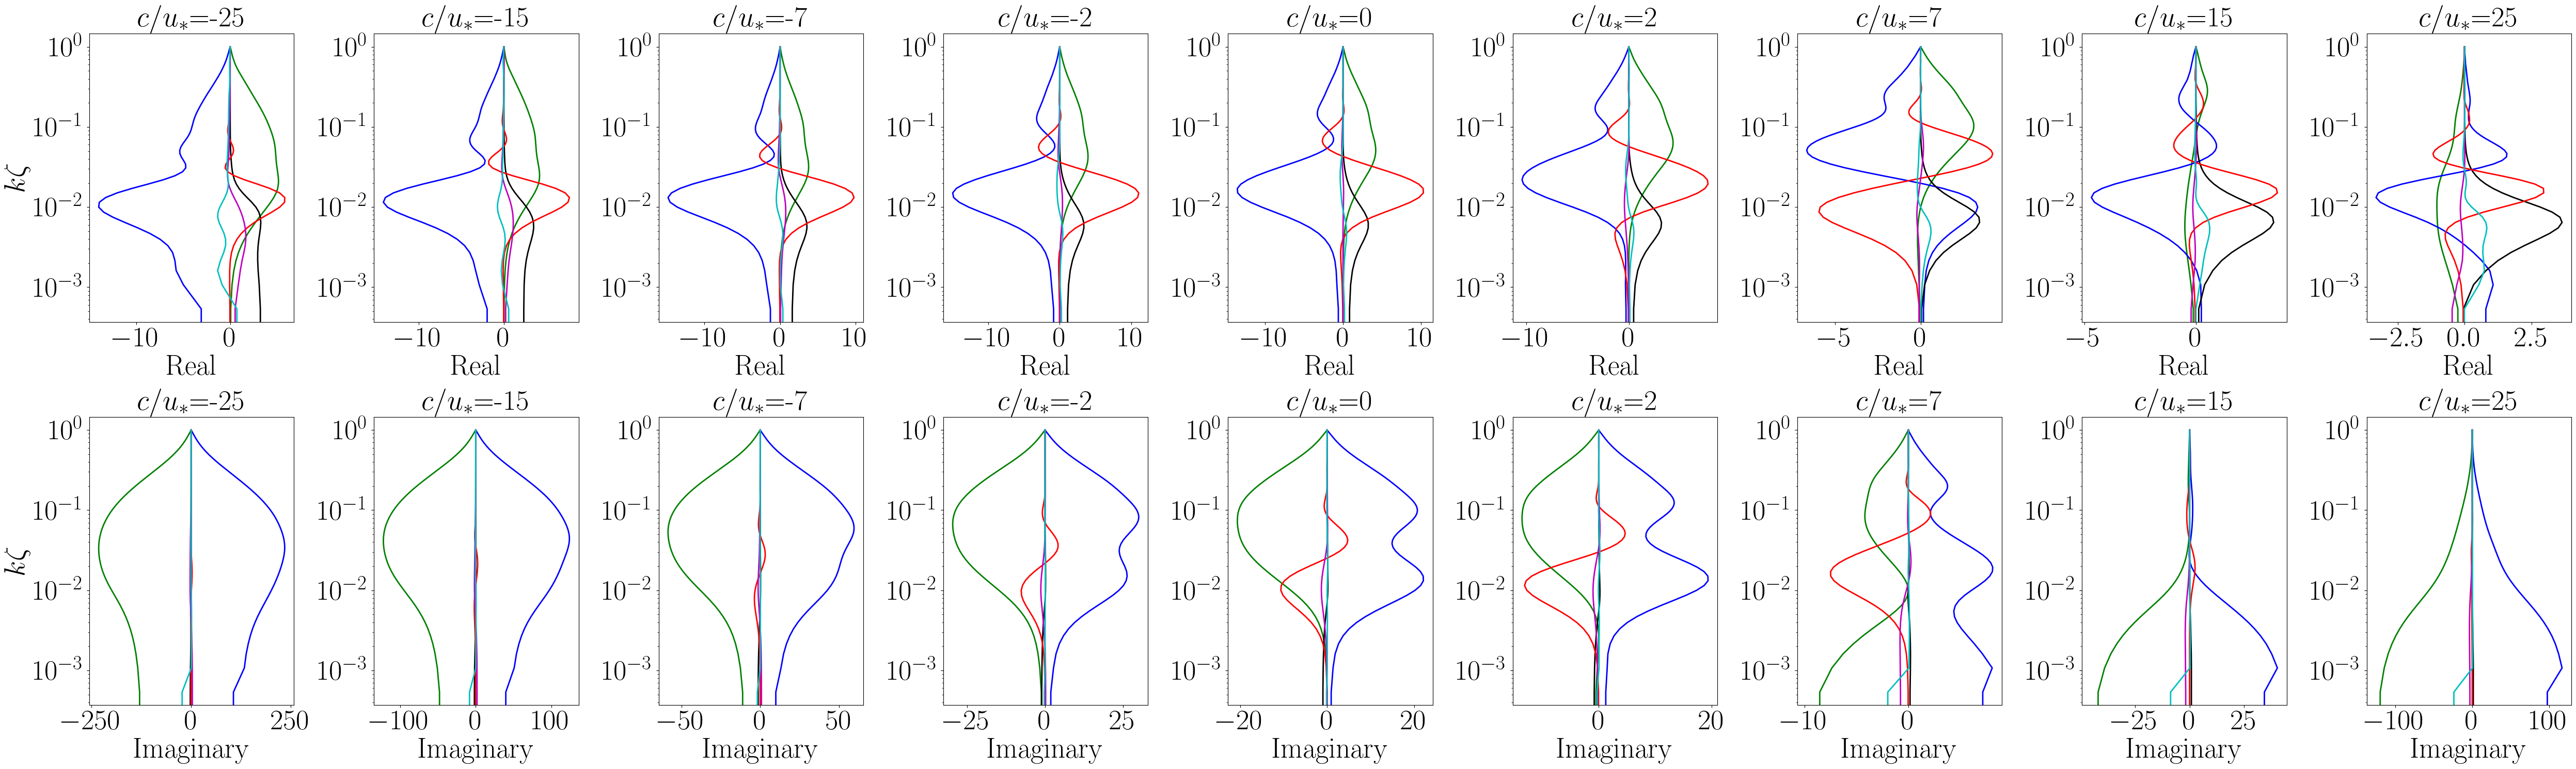

In [10]:
#w-momentum term by term balance
plt.figure(18,figsize=(50,15))

for num_data_select in range(9):
    
    z_data = np.asarray(LES_data[num_data_select].zw).flatten()
    U_data = np.asarray(LES_data[num_data_select].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)
    w_hat_LES= np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    dwhatdz=np.gradient(w_hat_LES[16,:],z_data,edge_order=2)
    d2whatdz2=np.gradient(dwhatdz,z_data,edge_order=2)
    
    tau31_nu_hat_LES= np.fft.fft(LES_data[num_data_select].tau31_nu,axis=0,norm='forward')
    tau33_nu_hat_LES= np.fft.fft(LES_data[num_data_select].tau33_nu,axis=0,norm='forward')
    dtau33_nu_dzeta = np.gradient(tau33_nu_hat_LES[16,:],z_data,edge_order=2)
    
    tau31_hat_LES = np.fft.fft(LES_data[num_data_select].tau31+LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')
    tau33_hat_LES = np.fft.fft(LES_data[num_data_select].tau33+LES_data[num_data_select].tau33_SGS,axis=0,norm='forward')
    dtau33_dzeta = np.gradient(tau33_hat_LES[16,:],z_data,edge_order=2)
    
    tau31_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau31_wave,axis=0,norm='forward')
    tau33_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau33_wave,axis=0,norm='forward')
    dtau33_wave_dzeta = np.gradient(tau33_wave_hat_LES[16,:],z_data,edge_order=2)
    
    p_hat_LES= np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    dphatdz=np.gradient(p_hat_LES[16,:],z_data,edge_order=2)
    
    
    adv_term=(U_data-c_array[num_data_select])*1j*k_wavno*w_hat_LES[16,:]
    dpdz_term=dphatdz
    visc_term=-nu*(-k_wavno**2*w_hat_LES[16,:]+d2whatdz2)#1j*k_wavno*tau31_nu_hat_LES[16,:]+dtau33_nu_dzeta
    #visc_term=1j*k_wavno*tau31_nu_hat_LES[16,:]+dtau33_nu_dzeta
    turb_term=1j*k_wavno*tau31_hat_LES[16,:]+dtau33_dzeta
    wave_term=1j*k_wavno*tau31_wave_hat_LES[16,:]+dtau33_wave_dzeta
    full_term=adv_term+dpdz_term+visc_term+turb_term+wave_term
    
    ax1=plt.subplot(2,9,num_data_select+1)

    plt.semilogy(adv_term.imag,z_data,'g',linewidth=2)
    plt.semilogy(dpdz_term.imag,z_data,'b',linewidth=2)
    plt.semilogy(visc_term.imag,z_data,'k',linewidth=2)
    plt.semilogy(turb_term.imag,z_data,'r',linewidth=2)
    plt.semilogy(wave_term.imag,z_data,'m',linewidth=2)
    plt.semilogy(full_term.imag,z_data,'c',linewidth=2)
    
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=font_size)
    if num_data_select == 0:
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    ax1.set_xlabel(r'Real',fontsize=font_size)
    
    ax1.tick_params(labelsize=font_size)
    
    ax1=plt.subplot(2,9,9+num_data_select+1)
    
    plt.semilogy(adv_term.real,z_data,'g',linewidth=2)
    plt.semilogy(dpdz_term.real,z_data,'b',linewidth=2)
    plt.semilogy(visc_term.real,z_data,'k',linewidth=2)
    plt.semilogy(turb_term.real,z_data,'r',linewidth=2)
    plt.semilogy(wave_term.real,z_data,'m',linewidth=2)
    plt.semilogy(full_term.real,z_data,'c',linewidth=2)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=font_size)
    if num_data_select == 0:
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    ax1.set_xlabel(r'Imaginary',fontsize=font_size)
    
    ax1.tick_params(labelsize=font_size)

    # ax1=plt.subplot(9,3,num_data_select*3+3)
    # plt.semilogy(w_hat_LES[16,:].real,z_data,'ro')
    # plt.semilogy(w_hat_LES[16,:].imag,z_data,'bv')
    # ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
plt.savefig('w_momentum_budget.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()

\begin{align*}
\left[(\langle{u}\rangle-c)\left(\frac{\partial^2}{\partial\zeta^2}-k^2\right)-\frac{\partial^2\langle{u}\rangle}{\partial\zeta^2}-\frac{\nu}{\mathrm{i}k}\left[\frac{\partial^4}{\partial\zeta^4}-2k^2\frac{\partial^2}{\partial\zeta^2}+k^4\right]\right]\hat{w}&
     =\nu\hat{\eta}\frac{\partial^2}{\partial\zeta^2}\left[g\frac{\partial^2\langle u\rangle}{\partial\zeta^2}\right]\\
     &\mspace{20mu}+\mathrm{i}k\frac{\partial}{\partial\zeta}(\hat{\tau}^{w}_{11}+\hat{\tau}_{11})+\frac{\partial^2}{\partial \zeta^2}(\hat{\tau}^{w}_{13}+\hat{\tau}_{13})\\
     &\mspace{20mu}+k^2(\hat{\tau}^{w}_{31}+\hat{\tau}_{31})-\mathrm{i}k\frac{\partial}{\partial \zeta}(\hat{\tau}^{w}_{33}+\hat{\tau}_{33})
\end{align*}

/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_61790/3247023917.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=18,frameon=False)


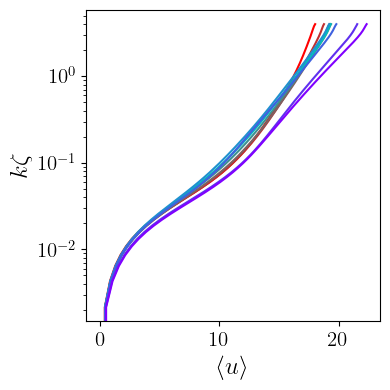

In [11]:
#Velocity plot
plt.figure(18,figsize=(4,4))
legend_name=['$c/u_*=-25$','$c/u_*=-15$','$c/u_*=-7$','$c/u_*=-2$','$c/u_*=0$','$c/u_*=2$','$c/u_*=7$','$c/u_*=15$','$c/u_*=25$']
ax1=plt.subplot(111)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    u_data = np.asarray(LES_data[n].u_mean).flatten()
    U_data = np.asarray(LES_data[n].U_mean).flatten()
    
    ax1.semilogy(u_data,k_wavno*z_data,color=color_array[n])
    
#ax1.legend(bbox_to_anchor=(1.2, 1))

ax1.set_ylabel(r'$k\zeta$',fontsize=18)
ax1.set_xlabel(r'$\langle u \rangle$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,1.2)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=18,frameon=False)

#plt.savefig('vel_NAWEA.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)

plt.show()

/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_61790/4176841817.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=18,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_61790/4176841817.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=18,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_61790/4176841817.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=18,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_61790/4176841817.py:64: UserWarning: No artists with labels fo

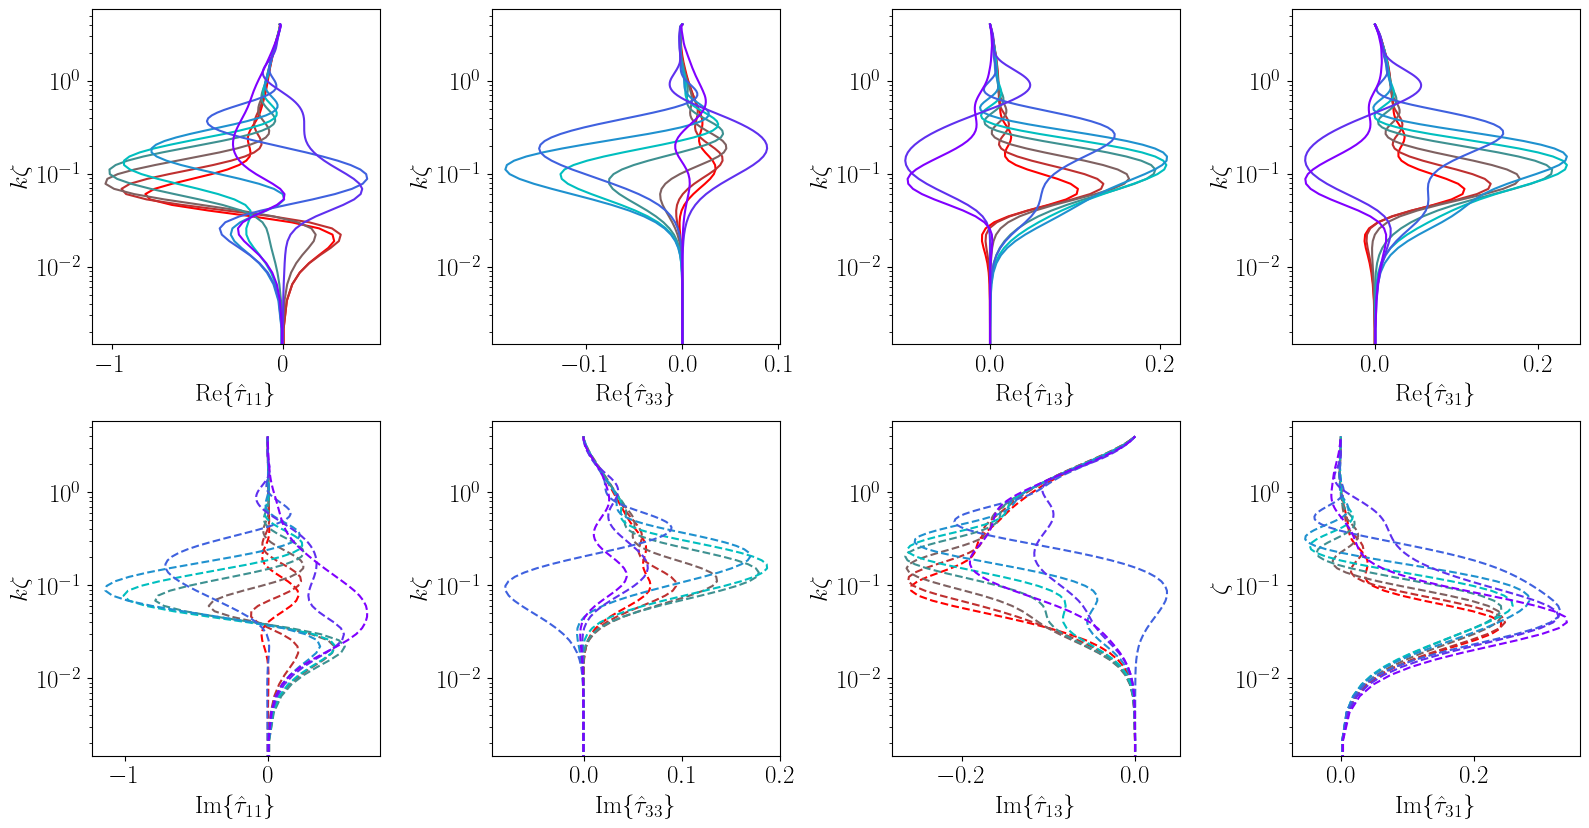

In [12]:
#Stress plot
plt.figure(18,figsize=(16,16))
# ax1=plt.subplot(341)
# for n in range(num_data):
#     z_data = np.asarray(LES_data[n].zw).flatten()
#     u_data = np.asarray(LES_data[n].u_mean).flatten()
#     U_data = np.asarray(LES_data[n].U_mean).flatten()
    
#     ax1.semilogy(u_data,z_data,color=color_array[n])
    

# ax1.set_ylabel(r'$\zeta$',fontsize=18)
# ax1.set_xlabel(r'$\langle u \rangle$',fontsize=18)
# #ax1.set_xticks([0,.5,1.0])
# #ax1.set_yticks([0.5,1])
# #ax1.tick_params(labelsize=18)
# #ax1.set_xlim(0.,1.2)
# #ax1.set_ylim(0,1)
# ax1.tick_params(labelsize=15)
# ax1.legend(fontsize=18,frameon=False)

ax1=plt.subplot(441)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau11_hat_LES[16,:].real,k_wavno*z_data,color=color_array[n])
    
ax1.set_ylabel(r'$k\zeta$',fontsize=18)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{11}\}$',fontsize=18)
ax1.tick_params(labelsize=18)
ax1.legend(fontsize=18,frameon=False)

ax1=plt.subplot(445)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau11_hat_LES[16,:].imag,k_wavno*z_data,color=color_array[n],linestyle='--')

    ax1.set_ylabel(r'$k\zeta$',fontsize=18)
ax1.set_xlabel(r'Im$\{\hat{\tau}_{11}\}$',fontsize=18)
ax1.tick_params(labelsize=18)
ax1.legend(fontsize=18,frameon=False)

ax1=plt.subplot(442)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33+LES_data[n].tau33_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau33_hat_LES[16,:].real,k_wavno*z_data,color=color_array[n])
    
ax1.set_ylabel(r'$k\zeta$',fontsize=18)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{33}\}$',fontsize=18)
ax1.tick_params(labelsize=18)
ax1.legend(fontsize=18,frameon=False)

ax1=plt.subplot(446)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33+LES_data[n].tau33_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau33_hat_LES[16,:].imag,k_wavno*z_data,color=color_array[n],linestyle='--')

    ax1.set_ylabel(r'$k\zeta$',fontsize=18)
ax1.set_xlabel(r'Im$\{\hat{\tau}_{33}\}$',fontsize=18)
ax1.tick_params(labelsize=18)
ax1.legend(fontsize=18,frameon=False)

########################################################################################################################################################

ax1=plt.subplot(443)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13+LES_data[n].tau13_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau13_hat_LES[16,:].real,k_wavno*z_data,color=color_array[n])
    
ax1.set_ylabel(r'$k\zeta$',fontsize=18)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{13}\}$',fontsize=18)
ax1.tick_params(labelsize=18)
ax1.legend(fontsize=18,frameon=False)

ax1=plt.subplot(447)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13+LES_data[n].tau13_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau13_hat_LES[16,:].imag,k_wavno*z_data,color=color_array[n],linestyle='--')

    ax1.set_ylabel(r'$k\zeta$',fontsize=18)
ax1.set_xlabel(r'Im$\{\hat{\tau}_{13}\}$',fontsize=18)
ax1.tick_params(labelsize=18)
ax1.legend(fontsize=18,frameon=False)

ax1=plt.subplot(444)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31+LES_data[n].tau31_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau31_hat_LES[16,:].real,k_wavno*z_data,color=color_array[n])
    
ax1.set_ylabel(r'$k\zeta$',fontsize=18)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{31}\}$',fontsize=18)
ax1.tick_params(labelsize=18)
ax1.legend(fontsize=18,frameon=False)

ax1=plt.subplot(448)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31+LES_data[n].tau31_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau31_hat_LES[16,:].imag,k_wavno*z_data,color=color_array[n],linestyle='--')

    ax1.set_ylabel(r'$\zeta$',fontsize=18)
ax1.set_xlabel(r'Im$\{\hat{\tau}_{31}\}$',fontsize=18)
ax1.tick_params(labelsize=18)
ax1.legend(fontsize=18,frameon=False)

#plt.savefig('tau_ij_plot_NAWEA.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)

plt.show()

/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_61790/1625634202.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=18,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_61790/1625634202.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=18,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_61790/1625634202.py:106: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=18,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_61790/1625634202.py:137: UserWarning: No artists with labels 

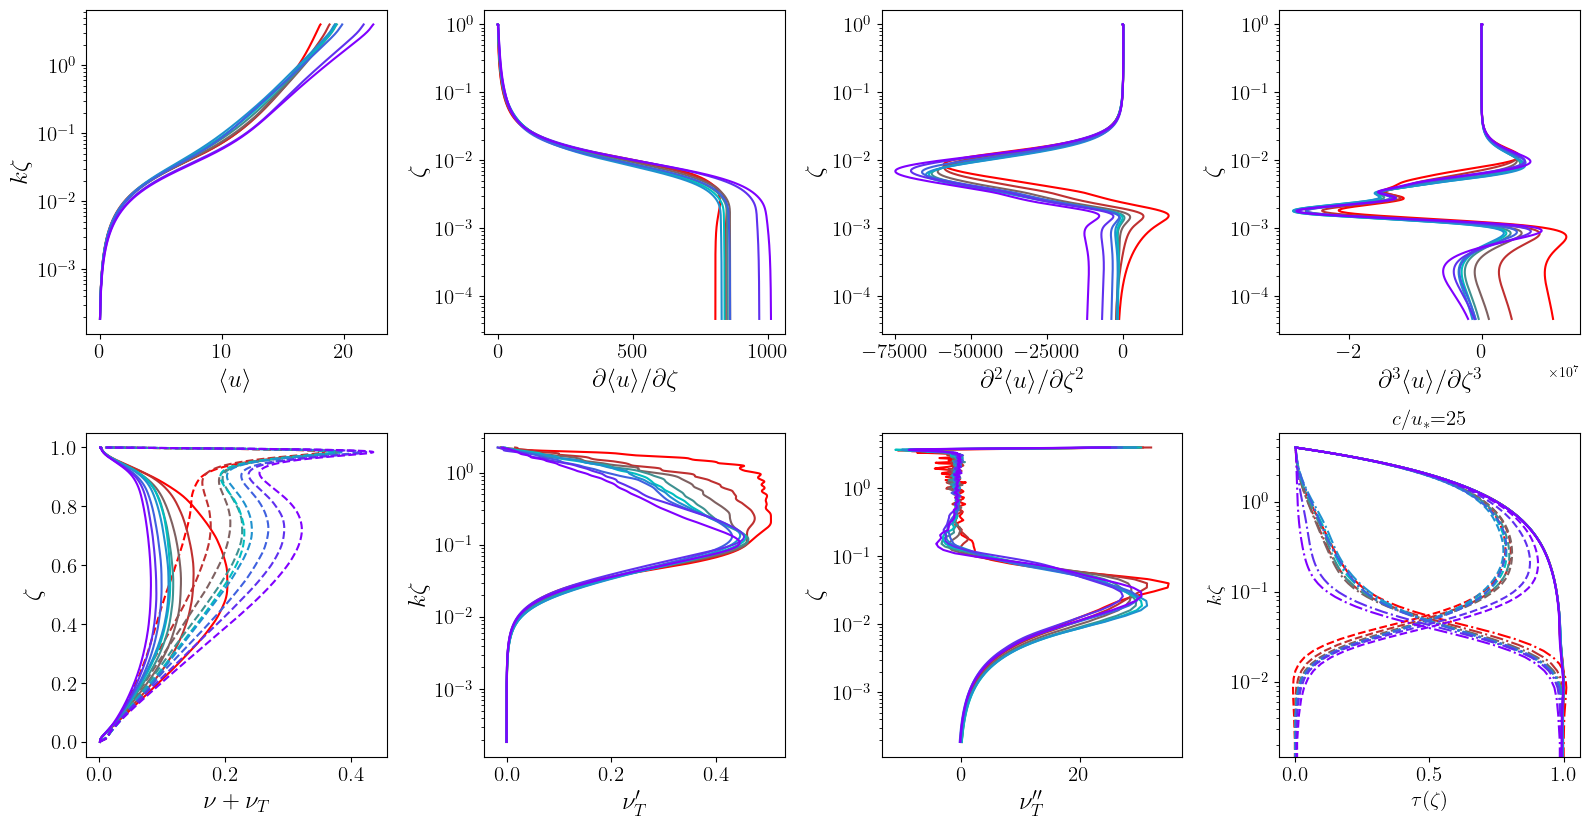

In [13]:
plt.figure(18,figsize=(16,12))
z=z_non_uniform
ax1=plt.subplot(341)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U        = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime        = U_prime_spline(z)
    
    U_double_prime_LES    = U_spline.derivative(nu=2)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_double_prime_spline = CubicSpline(z_data[0:-1],U_double_prime_LES)
    U_double_prime        = U_double_prime_spline(z)
    
    U_triple_prime_LES    = U_spline.derivative(nu=3)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_triple_prime_spline = CubicSpline(z_data[0:-1],U_triple_prime_LES)
    U_triple_prime        = U_triple_prime_spline(z)
    
    ax1.semilogy(U,k_wavno*z_non_uniform,color=color_array[n])
    
#ax1.semilogy(U_model,z_non_uniform,color='k',linestyle='--')
#ax1.semilogy(U_model_1,z_non_uniform,color='m',linestyle='--')

ax1.set_ylabel(r'$k\zeta$',fontsize=18)
ax1.set_xlabel(r'$\langle u \rangle$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,1.2)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=18,frameon=False)

ax1=plt.subplot(342)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U        = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime        = U_prime_spline(z)
    
    U_double_prime_LES    = U_spline.derivative(nu=2)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_double_prime_spline = CubicSpline(z_data[0:-1],U_double_prime_LES)
    U_double_prime        = U_double_prime_spline(z)
    
    U_triple_prime_LES    = U_spline.derivative(nu=3)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_triple_prime_spline = CubicSpline(z_data[0:-1],U_triple_prime_LES)
    U_triple_prime        = U_triple_prime_spline(z)
    
    ax1.semilogy(U_prime,z_non_uniform,color=color_array[n])
    
#ax1.semilogy(dUdz_model,z_non_uniform,'k--')
#ax1.semilogy(dUdz_model_1,z_non_uniform,'m--')

ax1.set_ylabel(r'$\zeta$',fontsize=18)
ax1.set_xlabel(r'$\partial\langle u \rangle/\partial\zeta$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,1.2)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=18,frameon=False)


ax1=plt.subplot(343)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U        = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime        = U_prime_spline(z)
    
    U_double_prime_LES    = U_spline.derivative(nu=2)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_double_prime_spline = CubicSpline(z_data[0:-1],U_double_prime_LES)
    U_double_prime        = U_double_prime_spline(z)
    
    U_triple_prime_LES    = U_spline.derivative(nu=3)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_triple_prime_spline = CubicSpline(z_data[0:-1],U_triple_prime_LES)
    U_triple_prime        = U_triple_prime_spline(z)

    ax1.semilogy(U_double_prime,z_non_uniform,color=color_array[n])
    
#ax1.semilogy(d2Udz2_model,z_non_uniform,'k--')
#ax1.semilogy(d2Udz2_model_1,z_non_uniform,'c-.')
    
ax1.set_ylabel(r'$\zeta$',fontsize=18)
ax1.set_xlabel(r'$\partial^2\langle u \rangle/\partial\zeta^2$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
ax1.tick_params(labelsize=15)
#ax1.set_xlim(0.,1.2)
#ax1.set_ylim(0,1)
ax1.legend(fontsize=18,frameon=False)

ax1=plt.subplot(344)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U        = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime        = U_prime_spline(z)
    
    U_double_prime_LES    = U_spline.derivative(nu=2)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_double_prime_spline = CubicSpline(z_data[0:-1],U_double_prime_LES)
    U_double_prime        = U_double_prime_spline(z)
    
    U_triple_prime_LES    = U_spline.derivative(nu=3)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_triple_prime_spline = CubicSpline(z_data[0:-1],U_triple_prime_LES)
    U_triple_prime        = U_triple_prime_spline(z)

    ax1.semilogy(U_triple_prime,z_non_uniform,color=color_array[n])
    
ax1.set_xlabel(r'$\partial^3\langle u\rangle/\partial\zeta^3$',fontsize=18)
ax1.set_ylabel(r'$\zeta$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
ax1.tick_params(labelsize=15)
#ax1.set_xlim(0.,1.2)
#ax1.set_ylim(0,1)
ax1.legend(fontsize=18,frameon=False)


ax1=plt.subplot(345)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U        = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime        = U_prime_spline(z)
    

    nuT_LES    = -(LES_data[n].tau13_mean[0:-1]+LES_data[n].tau13_SGS_mean[0:-1])/U_prime_LES
    nuT_spline = CubicSpline(z_data[0:-1],nuT_LES)
    nuT        = nuT_spline(z)
    
    nuT_prime  = nuT_spline.derivative()(z)
    nuT_double_prime  = nuT_spline.derivative(nu=2)(z)
  
    ax1.plot(nu+nuT,z,color=color_array[n])
    ax1.plot(nu+ ustar**2*kappa**2*z**2*U_prime,z,color=color_array[n],linestyle='--')
    #ax1.loglog((LES_data[n].tau13[0:-1]+LES_data[n].tau13_wave[0:-1]+LES_data[n].tau13_SGS[0:-1])/dUdz_LES,z_data[0:-1],color=color_array[n])
    
    #ax1.loglog((1-z_non_uniform)/dUdz_LES,z_non_uniform,color=color_array[n])
#ax1.loglog(nu*0+nuT_Cess,z_non_uniform,color='k',linestyle='--')
#ax1.loglog(nu_1*0+nuT_Cess_1,z_non_uniform,color='m',linestyle='--')

ax1.set_xlabel(r'$\nu+\nu_{T}$',fontsize=18)
ax1.set_ylabel(r'$\zeta$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,2*np.pi)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=18,frameon=False)


ax1=plt.subplot(346)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U        = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime        = U_prime_spline(z)
   

    nuT_LES    = -(LES_data[n].tau13_mean[0:-1]+LES_data[n].tau13_SGS_mean[0:-1])/U_prime_LES
    
    nuT_spline = CubicSpline(z_data[0:-1],nuT_LES)
    nuT        = nuT_spline(z)
    
    nuT_prime  = nuT_spline.derivative(nu=1)(z)
    nuT_double_prime  = nuT_spline.derivative(nu=2)(z)
  
    ax1.semilogy(nuT_prime[0:-1000],k_wavno*z[0:-1000],color=color_array[n])
    
    
#ax1.loglog((LES_data[n].tau13[0:-1]+LES_data[n].tau13_wave[0:-1]+LES_data[n].tau13_SGS[0:-1])/dUdz_LES,z_data[0:-1],color=color_array[n])
#ax1.loglog((1-z_non_uniform)/dUdz_LES,z_non_uniform,color=color_array[n])
#ax1.loglog(nu*0+nuT_Cess,z_non_uniform,color='k',linestyle='--')
#ax1.loglog(nu_1*0+nuT_Cess_1,z_non_uniform,color='m',linestyle='--')

ax1.set_xlabel(r'$\nu_T^{\prime}$',fontsize=18)
ax1.set_ylabel(r'$k\zeta$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,2*np.pi)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=18,frameon=False)


ax1=plt.subplot(347)
for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U        = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime        = U_prime_spline(z)
   

    nuT_LES    = -(LES_data[n].tau13_mean[0:-1]+LES_data[n].tau13_SGS_mean[0:-1])/U_prime_LES
    
    nuT_spline = CubicSpline(z_data[0:-1],nuT_LES)
    nuT        = nuT_spline(z)
    
    nuT_prime  = nuT_spline.derivative(nu=1)(z)
    nuT_double_prime  = nuT_spline.derivative(nu=2)(z)
  
    ax1.semilogy(nuT_double_prime[0:-500],k_wavno*z[0:-500],color=color_array[n])
    
    #ax1.loglog((LES_data[n].tau13[0:-1]+LES_data[n].tau13_wave[0:-1]+LES_data[n].tau13_SGS[0:-1])/dUdz_LES,z_data[0:-1],color=color_array[n])
    
    #ax1.loglog((1-z_non_uniform)/dUdz_LES,z_non_uniform,color=color_array[n])
#ax1.loglog(nu*0+nuT_Cess,z_non_uniform,color='k',linestyle='--')
#ax1.loglog(nu_1*0+nuT_Cess_1,z_non_uniform,color='m',linestyle='--')

ax1.set_xlabel(r'$\nu_T^{\prime\prime}$',fontsize=18)
ax1.set_ylabel(r'$\zeta$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,2*np.pi)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=18,frameon=False)


ax1=plt.subplot(348)
for num_data_select in range(9):
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*1+LES_data[num_data_select].taup_13_mean*1+LES_data[num_data_select].tau13_mean*1+LES_data[num_data_select].tau13_wave_mean*1+1*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color=color_array[num_data_select],linestyle='-')
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*0+LES_data[num_data_select].taup_13_mean*0+LES_data[num_data_select].tau13_mean*1+LES_data[num_data_select].tau13_wave_mean*1+1*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color=color_array[num_data_select],linestyle='--')
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*1+LES_data[num_data_select].taup_13_mean*1+LES_data[num_data_select].tau13_mean*0+LES_data[num_data_select].tau13_wave_mean*0+0*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color=color_array[num_data_select],linestyle='-.')
ax1.set_xlabel(r'$\tau(\zeta)$',fontsize=15)
ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
ax1.set_ylabel(r'$k\zeta$',fontsize=15)
ax1.tick_params(labelsize=15)

#plt.savefig('vel_nuT_LES.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)
plt.show()

\begin{align}
    &-\Biggl[\mathrm{i}k\frac{\partial^2 \langle{u}\rangle}{\partial \zeta^2}-(\langle{u}\rangle-c)\mathrm{i}k\nabla^2
    +(\nu+\nu_T)\nabla^4+2\dfrac{\partial\nu_T}{\partial \zeta}\nabla^2D
    +\dfrac{\partial^2\nu_T}{\partial\zeta^2}\left(D^2+k^2\right)\Biggr]\dfrac{\hat{w}}{\mathrm{i}k}
     \nonumber \\
    &\mspace{20mu}=\hat{\eta}(\nu+\nu_T)\frac{\partial^2}{\partial\zeta^2}\left[g\frac{\partial^2\langle{u}\rangle}{\partial\zeta^2}\right]+\frac{\partial\nu_T}{\partial\zeta}\left(2\frac{\partial^2}{\partial\zeta^2}-k^2\right)g\hat{\eta}\frac{\partial \langle{u}\rangle}{\partial \zeta}+\frac{\partial^2\nu_T}{\partial\zeta^2}g\hat{\eta}\frac{\partial^2 \langle{u}\rangle}{\partial \zeta^2}, \\
    &\nabla^2=D^2-k^2, \ D=\partial/\partial\zeta.
\end{align}
\begin{align*}
\zeta=\frac{z-\eta}{H-\eta}
\end{align*}

Boundary conditions:

\begin{align*}
\eta(x,t)&=a\cos[k(x-ct)],\\
u_s(x,t)&=akc\cos[k(x-ct)],\\
w_s(x,t)&=akc\sin[k(x-ct)],\\
v_s(x,t)&=0.
\end{align*}

Phase-averaged boudnary conditions are:
\begin{align*}
\overline{\eta}=\widetilde{\eta}&=a\cos kx,\\
\overline{u}_s=\widetilde{u}_s&=akc\cos kx,\\
\overline{w}_s=\widetilde{w}_s&=akc\sin kx,\\
\overline{v}_s=\widetilde{v}_s&=0
\end{align*}

Pressure perturbation:


\begin{align*}
    \Re[\hat{p}]|_{\zeta}&= \int_{\zeta}^{\lambda}-(\langle{u}\rangle-c)k\text{Im}[\hat{w}]d\zeta- \int_{\zeta}^{\lambda}\nu_T\left(D^2-k^2\right)\text{Re}[\hat{w}]d\zeta\\
    &\mspace{20mu}- \int_{\zeta}^{\lambda}\frac{\partial\nu_T}{\partial\zeta}\left(2\frac{\partial\text{Re}[\hat{w}]}{\partial\zeta}-gk\Im[\hat{\eta}]\frac{\partial\langle{u}\rangle}{\partial\zeta}\right)d\zeta,\\
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    \Im[\hat{p}]|_{\zeta}&= \int_{\zeta}^{\lambda}(\langle{u}\rangle-c)k\text{Re}[\hat{w}]d\zeta-\int_{\zeta}^{\lambda}\nu_T\left(D^2-k^2\right)\text{Im}[\hat{w}]d\zeta\\
    &\mspace{20mu}-\int_{\zeta}^{\lambda}\frac{\partial\nu_T}{\partial\zeta}\left(2\frac{\partial\text{Im}[\hat{w}]}{\partial\zeta}+gk\Re[\hat{\eta}]\frac{\partial\langle{u}\rangle}{\partial\zeta}\right)d\zeta,\\
    \tilde{p}|_\zeta&=2\text{Re}[\hat{p}]|_\zeta\cos k\xi-2\text{Im}[\hat{p}]|_\zeta\sin k\xi
\end{align*}

Form drag:

\begin{align*}
F_p=\frac{1}{\lambda}\int_{0}^{\lambda}\frac{\widetilde{p}}{\rho_a u_\tau^2}\frac{d\widetilde{\eta}}{dx} \ dx
\end{align*}



\begin{align*}
\tilde{\tau}^\prime_{31}&=\tilde{\tau}_{31}-\frac{1}{3}\delta_{31}\tilde{\tau}_{kk}=-\nu_T\left(\frac{\partial\tilde{u}}{\partial\zeta}+\frac{\partial\tilde{w}}{\partial\xi}\right),\\
    \tilde{\tau}^\prime_{33}&=\tilde{\tau}_{33}-\frac{1}{3}\delta_{33}\tilde{\tau}_{kk}=\nu_T\left(\frac{\partial\tilde{u}}{\partial\xi}-\frac{\partial\tilde{w}}{\partial\zeta}\right)
\end{align*}

\begin{align*}
    \tilde{\tau}^{\prime}_{11}&=\tilde{\tau}_{11}-\frac{1}{3}\delta_{11}\tilde{\tau}_{kk}=2\nu_T\frac{\partial\tilde{w}}{\partial\zeta},\\
    \tilde{\tau}^{\prime}_{13}&=\tilde{\tau}_{13}-\frac{1}{3}\delta_{13}\tilde{\tau}_{kk}=-\nu_T\left(\frac{\partial\tilde{u}}{\partial\zeta}+\frac{\partial\tilde{w}}{\partial\xi}\right)-{\nu_T\frac{\partial\langle{u}\rangle}{\partial\zeta}g_\zeta\tilde{\eta}}.
\end{align*}

\begin{align*}
\left[(\langle{u\rangle}-c)\left(\frac{\partial^2}{\partial\zeta^2}-k^2\right)-\frac{\partial^2\langle{u\rangle}}{\partial\zeta^2}\right]\hat{w}&=\mathrm{i}k\frac{\partial}{\partial\zeta}(\hat{\tau}^{\nu}_{11}+\hat{\tau}^{w}_{11}+\hat{\tau}_{11})+\frac{\partial^2}{\partial \zeta^2}(\hat{\tau}^{\nu}_{13}+\hat{\tau}^{w}_{13}+\hat{\tau}_{13}),\\
    &\mspace{20mu}+k^2(\hat{\tau}^{\nu}_{31}+\hat{\tau}^{w}_{31}+\hat{\tau}_{31})-\mathrm{i}k\frac{\partial}{\partial \zeta}(\hat{\tau}^{\nu}_{33}+\hat{\tau}^{w}_{33}+\hat{\tau}_{33}).
\end{align*}


\begin{align*}
\hat{\tau}^\nu_{11}=-2\nu\frac{\partial \hat{w}}{\partial\zeta},\\
\hat{\tau}^\nu_{33}=\nu\left(\mathrm{i}k\hat{u}-\frac{\partial\hat{w}}{\partial\zeta}\right),\\
\end{align*}

/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_61790/1120970944.py:141: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0,0.25)


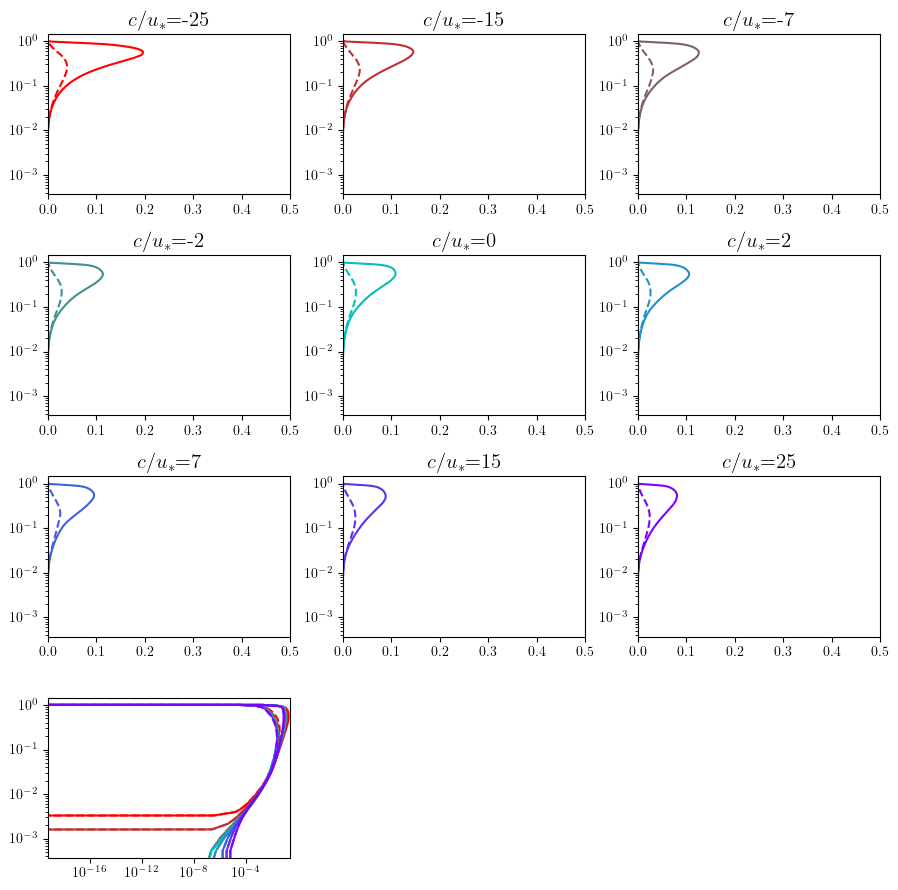

In [56]:
#Visualize tau_ij and nu_T
tau31_wave_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau13_wave_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau11_d_wave_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau33_d_wave_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)

tau31_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau13_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau11_d_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau33_d_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)

tau31_nu_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau13_nu_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau11_d_nu_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau33_d_nu_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)

tau31_SGS_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau13_SGS_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau11_d_SGS_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau33_d_SGS_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)

nuT_LES=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
plt.figure(11,figsize=(9,9))
for num_data_select in range(num_data):
    z_data = np.asarray(LES_data[num_data_select].zw).flatten()
    U_data = np.asarray(LES_data[num_data_select].U_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U_visc = U_spline(z)
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime_visc   = U_prime_spline(z)    
    tau13_mean_tot = -(LES_data[num_data_select].tau13_wave_mean[0:-1]*1+LES_data[num_data_select].tau13_mean[0:-1]+LES_data[num_data_select].tau13_SGS_mean[0:-1]).flatten()
    tau31_mean_tot = -(LES_data[num_data_select].tau31_mean[0:-1]+LES_data[num_data_select].tau31_SGS_mean[0:-1]).flatten()
    
    
    nuT_LES[:,num_data_select,0] = tau13_mean_tot/U_prime_LES
    
    #pow=1
    #zeta_plus=z_data[0:-1]*k_wavno
    #nuT_LES[:,num_data_select,1] = 0.41*z_data[0:-1]*(np.exp(-1*(zeta_plus-0.1)**2)) #(0.41*z_data[0:-1])**(1+pow)*(U_prime_LES)**pow
    #nuT_LES[:,num_data_select,1] = 0.41*z_data[0:-1]*(1-np.exp(-1*(zeta_plus-0.1)**1)) #(0.41*z_data[0:-1])**(1+pow)*(U_prime_LES)**pow
    
    nuT_LES[:,num_data_select,1] = nuT_LES[:,num_data_select,0]*np.exp(-1*k_wavno*z_data[0:-1])
    #Turbulent stress
    
    tau31_hat_LES = np.fft.fft(LES_data[num_data_select].tau31+LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')
    tau31_hat[:,num_data_select,0]=tau31_hat_LES[16,0:-1]
    
    tau13_hat_LES = np.fft.fft(LES_data[num_data_select].tau13+LES_data[num_data_select].tau13_SGS,axis=0,norm='forward')
    tau13_hat[:,num_data_select,0]=tau13_hat_LES[16,0:-1]
    
    tau11_d_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_d+LES_data[num_data_select].tau11_d_SGS,axis=0,norm='forward')
    tau11_d_hat[:,num_data_select,0]=tau11_d_hat_LES[16,0:-1]
    
    tau33_d_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_d+LES_data[num_data_select].tau33_d_SGS,axis=0,norm='forward')
    tau33_d_hat[:,num_data_select,0]=tau33_d_hat_LES[16,0:-1]

    #Viscous stress
    
    tau31_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau31_nu,axis=0,norm='forward')
    tau31_nu_hat[:,num_data_select,0]=tau31_nu_hat_LES[16,0:-1]
    
    tau13_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau13_nu,axis=0,norm='forward')
    tau13_nu_hat[:,num_data_select,0]=tau13_nu_hat_LES[16,0:-1]
    
    tau11_d_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_d_nu,axis=0,norm='forward')
    tau11_d_nu_hat[:,num_data_select,0]=tau11_d_nu_hat_LES[16,0:-1]
    
    tau33_d_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_d_nu,axis=0,norm='forward')
    tau33_d_nu_hat[:,num_data_select,0]=tau33_d_nu_hat_LES[16,0:-1]
    
    #Viscous stress-model
    w_hat_LES = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    dwhatdz_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1])
    
    u_hat_LES = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    duhatdz_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1])
    
    tau11_d_nu_hat[:,num_data_select,1]=-2*nu*dwhatdz_LES
    tau33_d_nu_hat[:,num_data_select,1]=nu*(1j*k_wavno*u_hat_LES[16,0:-1]-dwhatdz_LES)
    tau31_nu_hat[:,num_data_select,1]=-nu*(1j*k_wavno*w_hat_LES[16,0:-1]+duhatdz_LES)
    tau13_nu_hat[:,num_data_select,1]=-nu*(1j*k_wavno*w_hat_LES[16,0:-1]+duhatdz_LES)-nu*U_prime_LES*(1/zi)*(a/2)
    
    #Turbulent stress-model
    tau11_d_hat[:,num_data_select,1]=-2*nuT_LES[:,num_data_select,1]*dwhatdz_LES
    tau33_d_hat[:,num_data_select,1]=nuT_LES[:,num_data_select,1]*(1j*k_wavno*u_hat_LES[16,0:-1]-dwhatdz_LES)
    tau31_hat[:,num_data_select,1]=-nuT_LES[:,num_data_select,1]*(1j*k_wavno*w_hat_LES[16,0:-1]+duhatdz_LES)
    tau13_hat[:,num_data_select,1]=-nuT_LES[:,num_data_select,1]*(1j*k_wavno*w_hat_LES[16,0:-1]+duhatdz_LES)-nuT_LES[:,num_data_select,1]*U_prime_LES*(1/zi)*(a/2)
   
    
    ax1=plt.subplot(4,3,num_data_select+1)
    plt.semilogy(nuT_LES[:,num_data_select,0],z_data[0:-1],color=color_array[num_data_select])
    plt.semilogy(nuT_LES[:,num_data_select,1],z_data[0:-1],color=color_array[num_data_select],linestyle='--')
    
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_xlim(0,0.5)
    
    #SGS stress
    
    tau31_SGS_hat_LES = np.fft.fft(LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')
    tau31_SGS_hat[:,num_data_select,0]=tau31_SGS_hat_LES[16,0:-1]
    
    tau13_SGS_hat_LES = np.fft.fft(LES_data[num_data_select].tau13_SGS,axis=0,norm='forward')
    tau13_SGS_hat[:,num_data_select,0]=tau13_SGS_hat_LES[16,0:-1]
    
    tau11_d_SGS_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_d_SGS,axis=0,norm='forward')
    tau11_d_SGS_hat[:,num_data_select,0]=tau11_d_SGS_hat_LES[16,0:-1]
    
    tau33_d_SGS_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_d_SGS,axis=0,norm='forward')
    tau33_d_SGS_hat[:,num_data_select,0]=tau33_d_SGS_hat_LES[16,0:-1]
    
    
    #Wave-induced stress
    
    tau31_wave_hat_LES = np.fft.fft(LES_data[num_data_select].tau31_wave,axis=0,norm='forward')
    tau31_wave_hat[:,num_data_select,0]=tau31_wave_hat_LES[16,0:-1]
    
    tau13_wave_hat_LES = np.fft.fft(LES_data[num_data_select].tau13_wave,axis=0,norm='forward')
    tau13_wave_hat[:,num_data_select,0]=tau13_wave_hat_LES[16,0:-1]
    
    tau11_d_wave_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_d_wave,axis=0,norm='forward')
    tau11_d_wave_hat[:,num_data_select,0]=tau11_d_wave_hat_LES[16,0:-1]
    
    tau33_d_wave_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_d_wave,axis=0,norm='forward')
    tau33_d_wave_hat[:,num_data_select,0]=tau33_d_wave_hat_LES[16,0:-1]   
    
    u_hat_LES = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    duhatdz_LES=np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    
    w_hat_LES = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    dwhatdz_LES=np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    
   
    
ax1=plt.subplot(4,3,10)

for num_data_select in range(num_data):
    plt.loglog(nuT_LES[:,num_data_select,0],z_data[0:-1],color=color_array[num_data_select])
    plt.loglog(nuT_LES[:,num_data_select,1],z_data[0:-1],color=color_array[num_data_select],linestyle='--')
    
    ax1.set_xlim(0,0.25)
plt.show()

\begin{align*}
\hat{\tau}^\nu_{11}&=-2\nu\frac{\partial \hat{w}}{\partial\zeta},\\
\hat{\tau}^\nu_{33}&=\nu\left(\mathrm{i}k\hat{u}-\frac{\partial\hat{w}}{\partial\zeta}\right),\\
\hat{\tau}_{31}&=-\nu\left(\frac{\partial\hat{u}}{\partial\zeta}+\mathrm{i}k\hat{w}\right),\\
\hat{\tau}_{13}&=-\nu\left(\frac{\partial\hat{u}}{\partial\zeta}+\mathrm{i}k\hat{w}\right)-\nu\frac{\partial\langle u\rangle}{\partial\zeta}g_\zeta\hat{\eta}
\end{align*}

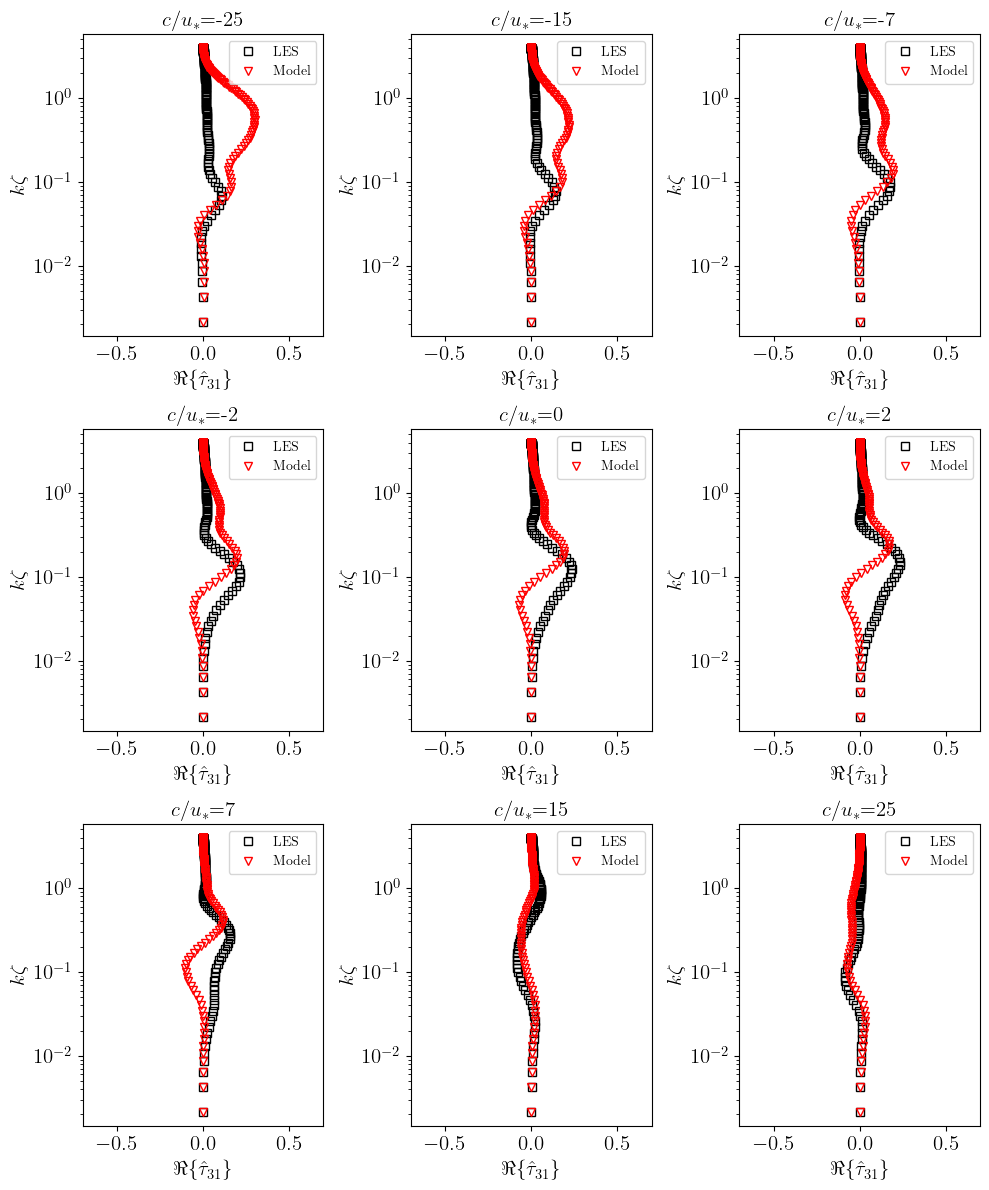

In [57]:
plt.figure(11,figsize=(10,12))
for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    w_hat_LES = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    dwhatdz_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1])
    
    u_hat_LES = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    duhatdz_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1])
    
    
    plot_real=1;
     
        
    if plot_real:
        #plt.semilogy((tau13_hat[:,num_data_select,0]).real,k_wavno*z_data[0:-1],'ko',markerfacecolor='none',label='LES')
        #plt.semilogy((tau13_hat[:,num_data_select,1]).real,k_wavno*z_data[0:-1],'rv',markerfacecolor='none',label='Model')
        plt.semilogy((tau31_hat[:,num_data_select,0]).real,k_wavno*z_data[0:-1],'ks',markerfacecolor='none',label='LES')
        plt.semilogy((tau31_hat[:,num_data_select,1]).real,k_wavno*z_data[0:-1],'rv',markerfacecolor='none',label='Model')
        
        #plt.semilogy((tau31_hat[:,num_data_select,1]).real*(0.5*(1-np.tanh(1e10*(z_data[0:-1]-0.1)**1))),k_wavno*z_data[0:-1],'rv',markerfacecolor='none',label='Model')
        
        #plt.semilogy(-(tau31_hat[:,num_data_select,0]).real/(1j*k_wavno*w_hat_LES[16,0:-1]+duhatdz_LES),k_wavno*z_data[0:-1],'ko',markerfacecolor='none',label='LES')
        
        #plt.semilogy(nuT_LES[:,num_data_select,1],k_wavno*z_data[0:-1],'rv',markerfacecolor='none',label='LES')
        
        #plt.semilogy((tau31_hat[:,num_data_select,1]).real*np.exp(-2*k_wavno*z_data[0:-1]),k_wavno*z_data[0:-1],'rv',markerfacecolor='none',label='Model')
        #plt.semilogy((tau31_nu_hat[:,num_data_select,1]).real,k_wavno*z_data[0:-1],'m*',markerfacecolor='none',label='$\Re\{\hat{\tau}_{31}\}$ (LES)')
        ax1.set_xlabel(r'$\Re\{\hat{\tau}_{31}\}$',fontsize=15)
        ax1.legend()
    else:
        plt.semilogy((tau31_hat[:,num_data_select,0]).real,k_wavno*z_data[0:-1],'co',markerfacecolor='none',label='$\Re\{\hat{\tau}_{31}\}$ (LES)')
       
        plt.semilogy((tau31_hat[:,num_data_select,0]).imag,k_wavno*z_data[0:-1],'ro',markerfacecolor='none',label='$\Re\{\hat{\tau}_{31}\}$ (LES)')
        plt.semilogy((tau31_hat[:,num_data_select,1]).imag*np.exp(-k_wavno*z_data[0:-1]),k_wavno*z_data[0:-1],'bv',markerfacecolor='none',label='$\Re\{\hat{\tau}_{31}\}$ (LES)')
        #plt.semilogy((tau31_nu_hat[:,num_data_select,1]).imag,k_wavno*z_data[0:-1],'m*',markerfacecolor='none',label='$\Re\{\hat{\tau}_{31}\}$ (LES)')
        ax1.set_xlabel(r'$\Im\{\hat{\tau}_{31}\}$',fontsize=15)
    ax1.set_xlim(-0.7,0.7)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)

plt.savefig('tau13_LES_vs_Model_exp_decay.png',format='png',dpi=600,bbox_inches='tight',
            transparent=False,pad_inches=0.01)
plt.show()

\begin{align*}
\left[(\langle{u\rangle}-c)\left(\frac{\partial^2}{\partial\zeta^2}-k^2\right)-\frac{\partial^2\langle{u\rangle}}{\partial\zeta^2}\right]\hat{w}&=\mathrm{i}k\frac{\partial}{\partial\zeta}(\hat{\tau}^{\nu}_{11}+\hat{\tau}^{w}_{11}+\hat{\tau}_{11})+\frac{\partial^2}{\partial \zeta^2}(\hat{\tau}^{\nu}_{13}+\hat{\tau}^{w}_{13}+\hat{\tau}_{13}),\\
    &\mspace{20mu}+k^2(\hat{\tau}^{\nu}_{31}+\hat{\tau}^{w}_{31}+\hat{\tau}_{31})-\mathrm{i}k\frac{\partial}{\partial \zeta}(\hat{\tau}^{\nu}_{33}+\hat{\tau}^{w}_{33}+\hat{\tau}_{33}).
\end{align*}

\begin{align*}
\left[(\langle{u}\rangle-c)\left(\frac{\partial^2}{\partial\zeta^2}-k^2\right)-\frac{\partial^2\langle{u}\rangle}{\partial\zeta^2}\right]\hat{w}&
     =\mathrm{i}k\frac{\partial}{\partial\zeta}(\hat{\tau}^{\nu}_{11}-\hat{\tau}^{\nu}_{33})+\frac{\partial^2\hat{\tau}^{\nu}_{13}}{\partial \zeta^2}+k^2(\hat{\tau}^{\nu}_{31})\\
     &\mspace{20mu}+\mathrm{i}k\frac{\partial}{\partial\zeta}(\hat{\tau}^{w}_{11}+\hat{\tau}_{11})+\frac{\partial^2}{\partial \zeta^2}(\hat{\tau}^{w}_{13}+\hat{\tau}_{13})\\
     &\mspace{20mu}+k^2(\hat{\tau}^{w}_{31}+\hat{\tau}_{31})-\mathrm{i}k\frac{\partial}{\partial \zeta}(\hat{\tau}^{w}_{33}+\hat{\tau}_{33})
\end{align*}

0
0 -25
n,N 0 2048
n,N 1 2048
n,N 2 2048


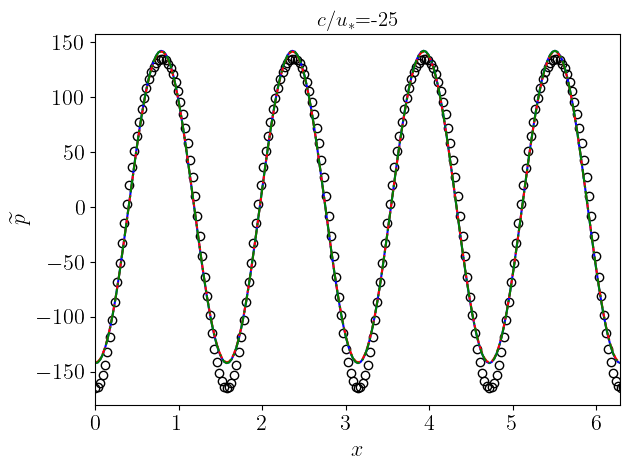

In [ ]:
w   = np.zeros((N,3,9),dtype=complex)
Rew = np.zeros((N,3,9),dtype=complex)
Imw = np.zeros((N,3,9),dtype=complex)
DRew = np.zeros((N,3,9),dtype=complex)
DImw = np.zeros((N,3,9),dtype=complex)
D2Rew = np.zeros((N,3,9),dtype=complex)
D2Imw = np.zeros((N,3,9),dtype=complex)
Reu = np.zeros((N,3,9),dtype=complex)
Imu = np.zeros((N,3,9),dtype=complex)
U = np.zeros((N,3,9),dtype=complex)
U_prime = np.zeros((N,3,9),dtype=complex)
U_double_prime = np.zeros((N,3,9),dtype=complex)
U_triple_prime = np.zeros((N,3,9),dtype=complex)

x = np.linspace(0,Lx,Nx)
y = a*np.cos(k_wavno*x)

Rep = np.zeros((N,4,3,9),dtype=complex)
Imp = np.zeros((N,4,3,9),dtype=complex)
n_num=3;
for num_data_select in range(9):
    print(num_data_select)
    c=c_array[num_data_select] # in meter per second
    print(num_data_select,c)
    filename_fig = [
        '01_SurfacePressure_ComparisonWithLES_case0.png',
        '01_SurfacePressure_ComparisonWithLES_case1.png',
        '01_SurfacePressure_ComparisonWithLES_case2.png',
        '01_SurfacePressure_ComparisonWithLES_case3.png',
        '01_SurfacePressure_ComparisonWithLES_case4.png',
        '01_SurfacePressure_ComparisonWithLES_case5.png',
        '01_SurfacePressure_ComparisonWithLES_case6.png',
        '01_SurfacePressure_ComparisonWithLES_case7.png',
        '01_SurfacePressure_ComparisonWithLES_case8.png'
    ]
    if num_data_select<7:
        z0=3.0e-4/2
    else:
        z0=1.5e-4
        #z0=1.75e-4 #case-8

    #Log-law model
    if use_non_uniform_grid:
        
        #Tanh-stretched grid
        z_min = z0  # Minimum value in the physical domain
        z_max = 1.0  # Maximum value in the physical domain
        alpha = 8.0  # Stretching factor (adjust for more/less stretching)

        # Create a linearly spaced grid in the range [0, 1]
        eta = np.linspace(-1, 1, N)

        # Apply the tanh stretching
        z_stretched = 0.5 * (np.tanh(alpha * eta) + 1)

        # Map the stretched grid to the desired physical domain
        z_non_uniform = z_min + z_stretched * (z_max - z_min)

        #z_non_uniform = np.logspace(np.log10(z0),np.log10(zi), N)
        z = z_non_uniform #np.logspace(np.log10(z0),np.log10(zi), N)
    else:
        z_uniform = np.linspace(z0,zi, N)
        z = z_uniform     #np.linspace(z0,zi, N)
    ###########################################################################################################################################################
    
    #Input from LES for viscous Curvilinear model
    z_data = np.asarray(LES_data[num_data_select].zw).flatten()
    U_data = np.asarray(LES_data[num_data_select].u_mean).flatten()
    
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U_visc = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime_visc   = U_prime_spline(z)
    
    
    U_double_prime_LES    = U_spline.derivative(nu=2)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_double_prime_spline = CubicSpline(z_data[0:-1],U_double_prime_LES)
    U_double_prime_visc   = U_double_prime_spline(z)
    
    U_triple_prime_LES    = U_spline.derivative(nu=3)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_triple_prime_spline = CubicSpline(z_data[0:-1],U_triple_prime_LES)
    U_triple_prime_visc   = U_triple_prime_spline(z)
    
    for n in range(3):
        U[:,n,num_data_select] = U_visc
        U_prime[:,n,num_data_select] = U_prime_visc
        U_double_prime[:,n,num_data_select] = U_double_prime_visc
        U_triple_prime[:,n,num_data_select] = U_triple_prime_visc

    ##########################################################################################################################################
    w_hat_LES = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    tau13_mean_tot_LES = -(LES_data[num_data_select].tau13_wave_mean[0:-1]*1+LES_data[num_data_select].tau13_mean[0:-1]+LES_data[num_data_select].tau13_SGS_mean[0:-1]).flatten()
    tau31_mean_tot_LES = -(LES_data[num_data_select].tau31_mean[0:-1]+LES_data[num_data_select].tau31_SGS_mean[0:-1]).flatten()
    
    
    nuT_linear = tau13_mean_tot_LES/U_prime_LES*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) 
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)
    
    tau11_hat_model_spline = CubicSpline(z_data[0:-1],tau11_hat_model)
    tau13_hat_model_spline = CubicSpline(z_data[0:-1],tau13_hat_model)
    tau31_hat_model_spline = CubicSpline(z_data[0:-1],tau31_hat_model)
    tau33_hat_model_spline = CubicSpline(z_data[0:-1],tau33_hat_model)
    dtau11_hat_dz_model_interp   = tau11_hat_model_spline.derivative(nu=1)(z)
    d2tau13_hat_dz2_model_interp = tau13_hat_model_spline.derivative(nu=2)(z)
    tau31_hat_model_interp = tau31_hat_model_spline(z)
    dtau33_hat_dz_model_interp = tau33_hat_model_spline.derivative(nu=1)(z)
    
    tau11_hat_LES = np.fft.fft(LES_data[num_data_select].tau11+LES_data[num_data_select].tau11_SGS,axis=0,norm='forward')
    tau13_hat_LES = np.fft.fft(LES_data[num_data_select].tau13+LES_data[num_data_select].tau13_SGS,axis=0,norm='forward')
    tau31_hat_LES = np.fft.fft(LES_data[num_data_select].tau31+LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')
    tau33_hat_LES = np.fft.fft(LES_data[num_data_select].tau33+LES_data[num_data_select].tau33_SGS,axis=0,norm='forward')
    
    tau11_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau11_wave,axis=0,norm='forward')
    tau13_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau13_wave,axis=0,norm='forward')
    tau31_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau31_wave,axis=0,norm='forward')
    tau33_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau33_wave,axis=0,norm='forward')

    tau11_hat_spline = CubicSpline(z_data[0:-1],tau11_hat_LES[16,0:-1])
    tau13_hat_spline = CubicSpline(z_data[0:-1],tau13_hat_LES[16,0:-1])
    tau31_hat_spline = CubicSpline(z_data[0:-1],tau31_hat_LES[16,0:-1])
    tau33_hat_spline = CubicSpline(z_data[0:-1],tau33_hat_LES[16,0:-1])
    
    tau11_wave_hat_spline = CubicSpline(z_data[0:-1],tau11_wave_hat_LES[16,0:-1])
    tau13_wave_hat_spline = CubicSpline(z_data[0:-1],tau13_wave_hat_LES[16,0:-1])
    tau31_wave_hat_spline = CubicSpline(z_data[0:-1],tau31_wave_hat_LES[16,0:-1])
    tau33_wave_hat_spline = CubicSpline(z_data[0:-1],tau33_wave_hat_LES[16,0:-1])
    
    tau11_hat_interp = tau11_hat_spline(z)
    tau13_hat_interp = tau13_hat_spline(z)
    tau31_hat_interp = tau31_hat_spline(z)
    tau33_hat_interp = tau33_hat_spline(z)
    
    tau11_wave_hat_interp = tau11_wave_hat_spline(z)
    tau13_wave_hat_interp = tau13_wave_hat_spline(z)
    tau31_wave_hat_interp = tau31_wave_hat_spline(z)
    tau33_wave_hat_interp = tau33_wave_hat_spline(z)
    
    dtau11_hat_dz_interp      = tau11_hat_spline.derivative(nu=1)(z)
    dtau11_wave_hat_dz_interp = tau11_wave_hat_spline.derivative(nu=1)(z)
    dtau33_hat_dz_interp      = tau33_hat_spline.derivative(nu=1)(z)
    dtau33_wave_hat_dz_interp = tau33_wave_hat_spline.derivative(nu=1)(z)
    
    d2tau13_hat_dz2_interp      = tau13_hat_spline.derivative(nu=2)(z)
    d2tau13_wave_hat_dz2_interp = tau13_wave_hat_spline.derivative(nu=1)(z)
    #########################################################################################################################################
    
    # Inhomogeneous term
    
    #g = lambda z, zi: z/zi -1
    g = z/zi-1
    g_zeta = 1/zi
    f_RHS  = np.zeros((N,4),dtype=complex)
    
    f_RHS[:,0] =  nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) 
          
    f_RHS[:,1] =   nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
                  +( 1j*k_wavno*dtau11_hat_dz_interp + d2tau13_hat_dz2_interp )\
                  +( k**2*tau31_hat_interp - 1j*k_wavno*dtau33_hat_dz_interp )
    
    #f_RHS[:,2] =   nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
    #              +1j*k_wavno*(dtau11_hat_dz_interp+dtau11_wave_hat_dz_interp) + d2tau13_hat_dz2_interp + d2tau13_wave_hat_dz2_interp \
    #              +k**2*(tau31_wave_hat_interp+tau31_hat_interp) -1j*k_wavno*(dtau33_hat_dz_interp+dtau33_wave_hat_dz_interp)

    f_RHS[:,2] =   nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
                   +( 1j*k_wavno*dtau11_hat_dz_model_interp + d2tau13_hat_dz2_model_interp )\
                   +( k**2*tau31_hat_model_interp - 1j*k_wavno*dtau33_hat_dz_model_interp )


    # Solve Orr-Sommerfeld equation
    
    if use_non_uniform_grid:
        ##Boundary conditions: [phi(-1), phi'(-1), phi(1), phi'(1)]
    
        w_s   = -1j*0.5*a*k_wavno*c

        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,0,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]

        w[:,0,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu*1, nuT*0, nuT_prime*0, nuT_double_prime*0  , k_wavno, U[:,0,num_data_select], c, U_double_prime[:,0,num_data_select], f_RHS[:,0],z_bc)
    
        ######################################################################################################################################################################################
       
        w_s   = -1j*0.5*a*k_wavno*c
       
        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,1,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]
        
        w[:,1,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu*1, nuT*0, nuT_prime*0, nuT_double_prime*0  , k_wavno, U[:,1,num_data_select], c, U_double_prime[:,1,num_data_select], f_RHS[:,1],z_bc)
        
        ######################################################################################################################################################################################
       
        w_s   = -1j*0.5*a*k_wavno*c

        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,2,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]
        
        w[:,2,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu*1, nuT*0, nuT_prime*0, nuT_double_prime*0  , k_wavno, U[:,2,num_data_select], c, U_double_prime[:,2,num_data_select], f_RHS[:,2],z_bc)
    else:
        print("Use non uniform grid")
       # w[:,0,num_data_select]    = orr_sommerfeld(N, z, nu*1, nuT*0, nuT_prime*0, nuT_double_prime*0  , k_wavno, U_visc, c, U_double_prime_visc, f_RHS[:,0],z_bc_nu)
       # w[:,1,num_data_select]    = orr_sommerfeld(N, z, nu*1, nuT*0, nuT_prime*0, nuT_double_prime*0  , k_wavno, U_visc, c, U_double_prime_visc, f_RHS[:,1],z_bc)
       # w[:,2,num_data_select]    = orr_sommerfeld(N, z, nu*1, nuT*0, nuT_prime*0, nuT_double_prime*0  , k_wavno, U_visc, c, U_double_prime_visc, f_RHS[:,2],z_bc)
        
        
    # Calculate Real and Imaginary parts of w perturbation
    for n in range(n_num):
        Rew[:,n,num_data_select]  = np.real(w[:,n,num_data_select])
        Imw[:,n,num_data_select]  = np.imag(w[:,n,num_data_select])
        DRew[:,n,num_data_select] = np.gradient(np.real(w[:,n,num_data_select]),z,edge_order=2)
        DImw[:,n,num_data_select] = np.gradient(np.imag(w[:,n,num_data_select]),z,edge_order=2)
        D2Rew[:,n,num_data_select]= np.gradient(DRew[:,n,num_data_select],z,edge_order=2)
        D2Imw[:,n,num_data_select]= np.gradient(DImw[:,n,num_data_select],z,edge_order=2)
        Reu[:,n,num_data_select]  = -(1/k_wavno)*DImw[:,n,num_data_select]-0.5*a*(-1)*U_prime[:,n,num_data_select]
        Imu[:,n,num_data_select]  =  (1/k_wavno)*DRew[:,n,num_data_select]
         
    #### Compute pressure
    g      = (z/zi-1)
    for n in range(n_num):
        print('n,N',n,N)
        for i in range(N):
            D2w_hat    =   D2Rew[i:,n,num_data_select]+1j*D2Imw[i:,n,num_data_select]
            p_hat_adv  =   np.trapz(1j*k_wavno*(U[i:,n,num_data_select]-c)*w[i:,n,num_data_select],z[i:])
            p_hat_visc =  -nu*np.trapz(-k_wavno**2*w[i:,n,num_data_select]+D2w_hat,z[i:])
            if n<2:
                p_hat_turb =  1j*k_wavno*np.trapz(tau31_hat_interp[i:],z[i:])+np.trapz(dtau33_hat_dz_interp[i:],z[i:])
            else:
                p_hat_turb =  1j*k_wavno*np.trapz(tau31_hat_model_interp[i:],z[i:])+np.trapz(dtau33_hat_dz_model_interp[i:],z[i:])

            
            Rep[i,0,n,num_data_select]=  p_hat_adv.real
            Rep[i,1,n,num_data_select]=  p_hat_visc.real
            Rep[i,2,n,num_data_select]=  p_hat_turb.real
            
            if n==0:
                Rep[i,3,n,num_data_select]=  Rep[i,0,n,num_data_select]+Rep[i,1,n,num_data_select]*0+Rep[i,2,n,num_data_select]*0
            else:
                Rep[i,3,n,num_data_select]=  Rep[i,0,n,num_data_select]+Rep[i,1,n,num_data_select]*0+Rep[i,2,n,num_data_select]
                
            Imp[i,0,n,num_data_select]=  p_hat_adv.imag
            Imp[i,1,n,num_data_select]=  p_hat_visc.imag
            Imp[i,2,n,num_data_select]=  p_hat_turb.imag
            
            if n==0:
                Imp[i,3,n,num_data_select]=  Imp[i,0,n,num_data_select]+Imp[i,1,n,num_data_select]*0+Imp[i,2,n,num_data_select]*0
            else:
                Imp[i,3,n,num_data_select]=  Imp[i,0,n,num_data_select]+Imp[i,1,n,num_data_select]*0+Imp[i,2,n,num_data_select]
    # plot it
    # f, (a0, a1, a2, a3) = plt.subplots(4, 1, gridspec_kw={'height_ratios': [10, 1, 10, 10]})
    fig, (a0) = plt.subplots(1, 1, gridspec_kw={'height_ratios': [5]})
    color_array_plot   =['b-','r--','g-.'];
    color_array_plot_Re=['b-','r--','g-.'];
    color_array_plot_Im=['b-','r--','g-.'];
    
    phase_diff=np.pi/2*0;
    a0.plot(x, LES_data[num_data_select].p_w_surf-np.mean(LES_data[num_data_select].p_w_surf),'ok',markerfacecolor='none',label='LES')
    
    for n in range(n_num):
        a0.plot(x, 2*Rep[0,3,n,num_data_select]*np.cos(k_wavno*x+phase_diff)*1-1*2*Imp[0,3,n,num_data_select]*np.sin(k_wavno*x+phase_diff),color_array_plot[n],label=r'$2Re\{\hat{p}\}\cos (k\xi)-2Im\{\hat{p}\}\sin (k\xi)$ (TurbCurv)')
    a0.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    a0.set_ylabel(r'$\widetilde{p}$',fontsize=16)
    a0.set_xlabel(r'$x$',fontsize=16)
    a0.tick_params(labelsize=16)
    a0.set_xlim(0,2*np.pi)
    #a0.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #a0.set_ylim(-1,1)
    fig.tight_layout()
    #plt.savefig(filename_fig[num_data_select],format='png',dpi=100,bbox_inches='tight', 
    #               transparent=False,
    #               pad_inches=0.01)

    filename_fig = [
        '01_what_profile_ComparisonWithLES_case0.png',
        '01_what_profile_ComparisonWithLES_case1.png',
        '01_what_profile_ComparisonWithLES_case2.png',
        '01_what_profile_ComparisonWithLES_case3.png',
        '01_what_profile_ComparisonWithLES_case4.png',
        '01_what_profile_ComparisonWithLES_case5.png',
        '01_what_profile_ComparisonWithLES_case6.png',
        '01_what_profile_ComparisonWithLES_case7.png',
        '01_what_profile_ComparisonWithLES_case8.png'
    ]
    
    plt.figure(11,figsize=(12,8))
    
    ax1=plt.subplot(231)
    for n in range(n_num):
        plt.semilogy(Rew[:,n,num_data_select],k_wavno*z,color_array_plot_Re[n],label='$\Re\{\hat{w}\}$ (Model)')
        
    w_LES_data = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    plt.semilogy(w_LES_data[16,:].real,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none',label='$\Re\{\hat{w}\}$ (LES)')
    
    
    ax1.set_xlabel(r'$\Re\{\hat{w}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
    
    #ax1.legend(fontsize=11, frameon=False, loc='upper right', bbox_to_anchor=(2, 1))
    #plt.savefig(filename_fig[num_data_select],format='png',dpi=100,bbox_inches='tight', 
    #               transparent=False,
    #               pad_inches=0.01)
    #plt.close()


    ax1=plt.subplot(232)
    for n in range(n_num):
        plt.semilogy(Reu[:,n,num_data_select],k_wavno*z,color_array_plot_Re[n])
        #plt.semilogy(Imu[:,n],k*z,color_array_plot_Im[n])
    #plt.semilogy(np.sqrt(   Reuopposing[:]**2+Imuopposing[:]**2),k*z,'b--',label='$|\hat{u}|$ (Model)')
    #plt.semilogy(np.sqrt(Reuopposing_nu[:]**2+Imuopposing_nu[:]**2),k*z,'b-.',label='$|\hat{u}_\nu|$ (Model)')
    
    u_LES_data = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    plt.semilogy(u_LES_data[16,:].real,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    #plt.semilogy(u_LES_data[16,:].imag,k*LES_data[num_data_select].zw,'mo',markerfacecolor='none')
    #plt.semilogy(np.abs(u_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{u}|$ (LES)')
    
    ax1.set_xlabel(r'$\Re\{\hat{u}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)

    ax1=plt.subplot(233)
    for n in range(n_num):
        plt.semilogy(Rep[:,3,n,num_data_select],k_wavno*z,color_array_plot_Re[n])
        #plt.semilogy(Imp[:,3,n],k*z,color_array_plot_Im[n])
    #plt.semilogy(np.sqrt(   Rep_opposing[:]**2+Imp_opposing[:]**2),k*z,'b--',label='$|\hat{p}|$ (Model)')
    #plt.semilogy(np.sqrt(Rep_opposing_nu[:]**2+Imp_opposing_nu[:]**2),k*z,'b-.',label='$|\hat{p}_\nu|$ (Model)')
    
    p_LES_data = np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    plt.semilogy(p_LES_data[16,:].real,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    #plt.semilogy(p_LES_data[16,:].imag,k*LES_data[num_data_select].zw,'mo',markerfacecolor='none')
    #plt.semilogy(np.abs(p_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{p}|$ (LES)')
    ax1.set_xlabel(r'$\Re\{\hat{p}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)


    ax1=plt.subplot(234)
    for n in range(n_num):
        #plt.semilogy(Rew[:,n],k*z,color_array_plot_Re[n],label='$\Re\{\hat{w}\}$ (Model)')
        plt.semilogy(Imw[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n],label='$\Im\{\hat{w}\}$ (Model)')
    #plt.semilogy(np.sqrt(Rewopposing[:]**2+Imwopposing[:]**2),k*z,'b--',label='$|\hat{w}|$ (Model)')
    #plt.semilogy(np.sqrt(Rewopposing_nu[:]**2+Imwopposing_nu[:]**2),k*z,'b-.',label='$|\hat{w}_\nu|$ (Model)')
    
    w_LES_data = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    #plt.semilogy(w_LES_data[16,:].real,k*LES_data[num_data_select].zw,'ko',markerfacecolor='none',label='$\Re\{\hat{w}\}$ (LES)')
    plt.semilogy(w_LES_data[16,:].imag,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none',label='$\Im\{\hat{w}\}$ (LES)')
    #plt.semilogy(np.abs(w_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{w}|$ (LES)')
    
    
    ax1.set_xlabel(r'$\Im\{\hat{w}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
    
    ax1=plt.subplot(235)
    for n in range(n_num):
        #plt.semilogy(Reu[:,n],k*z,color_array_plot_Re[n])
        plt.semilogy(Imu[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n])
    #plt.semilogy(np.sqrt(   Reuopposing[:]**2+Imuopposing[:]**2),k*z,'b--',label='$|\hat{u}|$ (Model)')
    #plt.semilogy(np.sqrt(Reuopposing_nu[:]**2+Imuopposing_nu[:]**2),k*z,'b-.',label='$|\hat{u}_\nu|$ (Model)')
    
    u_LES_data = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    #plt.semilogy(u_LES_data[16,:].real,k*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    plt.semilogy(u_LES_data[16,:].imag,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    #plt.semilogy(np.abs(u_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{u}|$ (LES)')
    
    ax1.set_xlabel(r'$\Im\{\hat{u}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
    
    ax1=plt.subplot(236)
    for n in range(n_num):
        #plt.semilogy(Rep[:,3,n],k*z,color_array_plot_Re[n])
        plt.semilogy(Imp[:,3,n,num_data_select],k_wavno*z,color_array_plot_Im[n])
    #plt.semilogy(np.sqrt(   Rep_opposing[:]**2+Imp_opposing[:]**2),k*z,'b--',label='$|\hat{p}|$ (Model)')
    #plt.semilogy(np.sqrt(Rep_opposing_nu[:]**2+Imp_opposing_nu[:]**2),k*z,'b-.',label='$|\hat{p}_\nu|$ (Model)')
    
    p_LES_data = np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    #plt.semilogy(p_LES_data[16,:].real,k*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    plt.semilogy(p_LES_data[16,:].imag,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    #plt.semilogy(np.abs(p_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{p}|$ (LES)')
    ax1.set_xlabel(r'$\Im\{\hat{p}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)

    #plt.savefig(filename_fig[num_data_select],format='png',dpi=600,bbox_inches='tight',
    #            transparent=False,pad_inches=0.01)
    plt.show()

In [115]:
color_array_plot   =['b-','r--','g-.'];
color_array_plot_Re=['b-','r--','g-.'];
color_array_plot_Im=['b-','r--','g-.'];

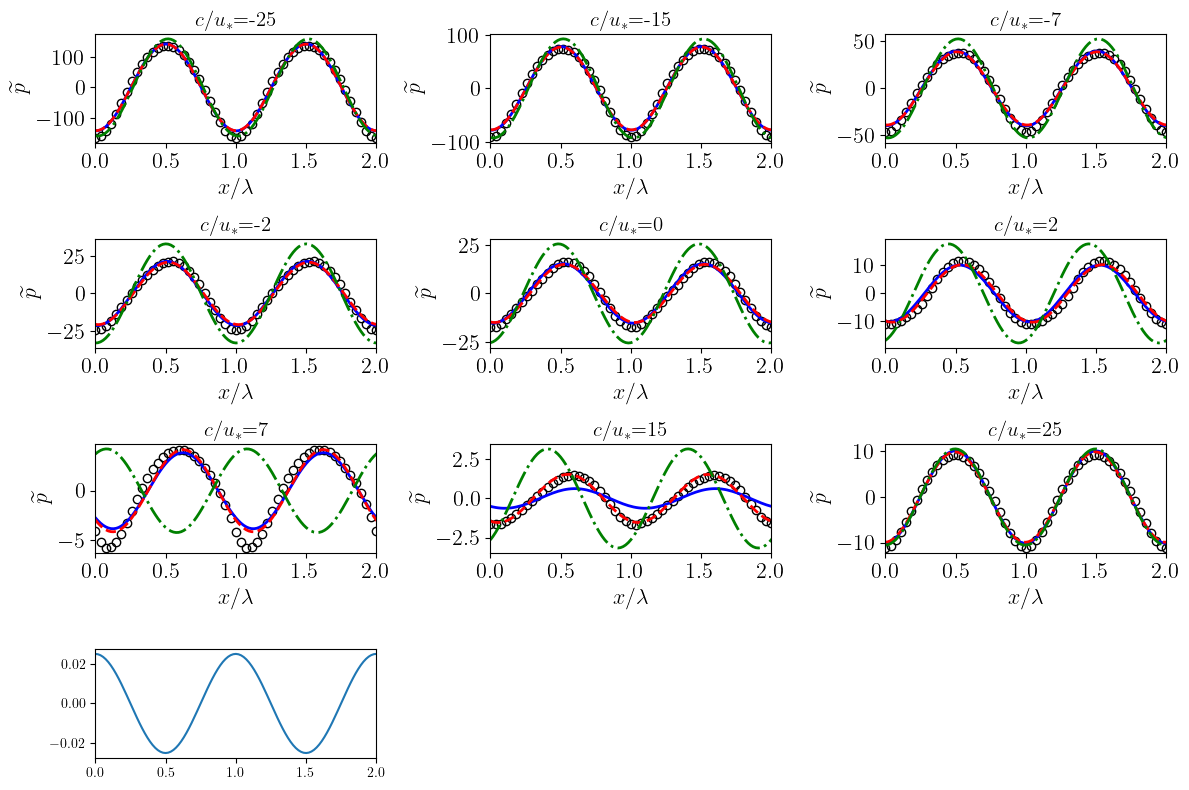

In [22]:
plt.figure(11,figsize=(12,8))
wavelength=2*np.pi/k_wavno
for num_data_select in range(9):
    ax1=plt.subplot(4,3,num_data_select+1)
    phase_diff=np.pi/2*0;
    ax1.plot(x[::2]/wavelength, LES_data[num_data_select].p_w_surf[::2]-np.mean(LES_data[num_data_select].p_w_surf[::2]),'ok',markerfacecolor='none',label='LES')

    for n in range(3):
        ax1.plot(x/wavelength, 2*Rep[0,3,n,num_data_select]*np.cos(k_wavno*x+phase_diff)*1-1*2*Imp[0,3,n,num_data_select]*np.sin(k_wavno*x+phase_diff),color_array_plot[n],label=r'$2Re\{\hat{p}\}\cos (k\xi)-2Im\{\hat{p}\}\sin (k\xi)$ (TurbCurv)',linewidth=2)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$\widetilde{p}$',fontsize=16)
    ax1.set_xlabel(r'$x/\lambda$',fontsize=16)
    ax1.tick_params(labelsize=16)
    ax1.set_xlim(0,2)
    
ax1=plt.subplot(4,3,10)
ax1.plot(x_LES/wavelength,y)
ax1.set_xlim(0,2)

plt.show()
    

#plt.savefig('p_surface_WRLES_vs_Model.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)

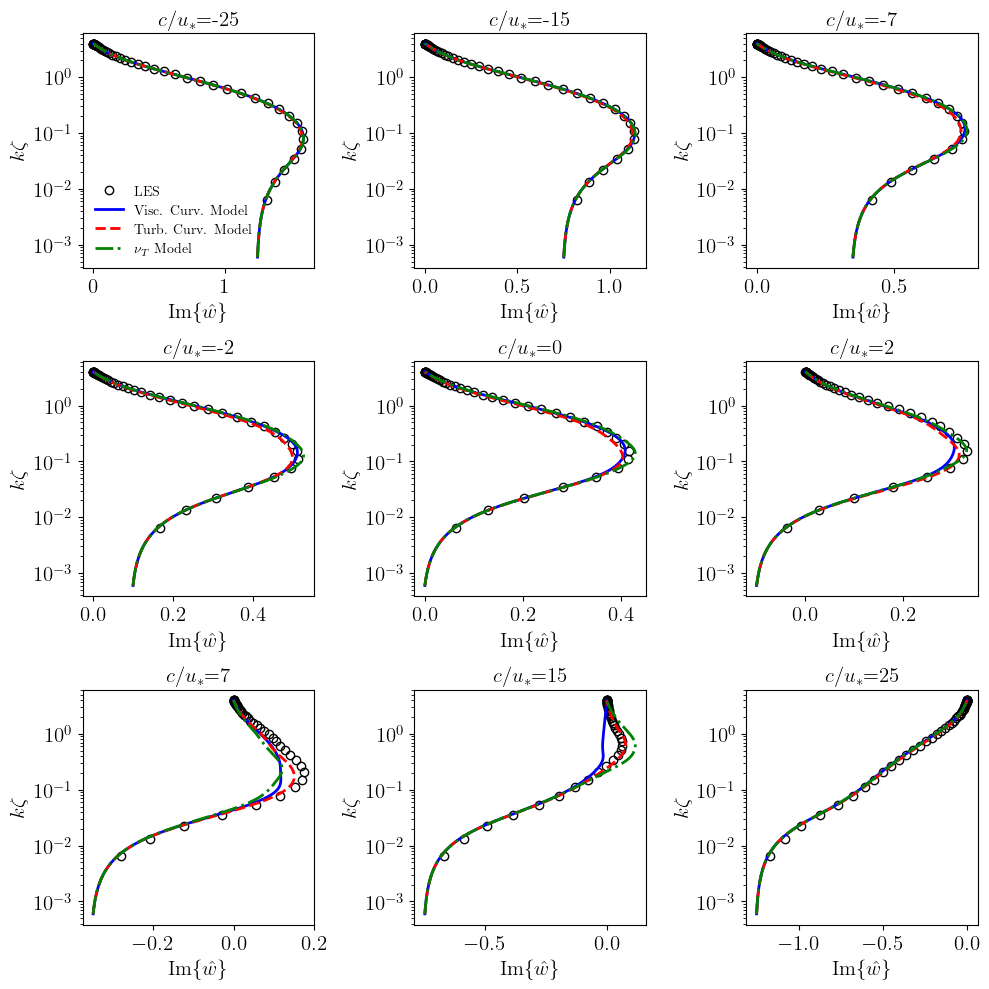

In [120]:
plt.figure(11,figsize=(10,10))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    w_LES_data = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    plt.semilogy(w_LES_data[16,::3].imag,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none',label='LES')
    #plt.semilogy(w_LES_data[16,:].real,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none',label='$\Im\{\hat{w}\}$ (LES)')
    
    label_name=['Visc. Curv. Model','Turb. Curv. Model','$\\nu_T$ Model']
    for n in range(3):
        plt.semilogy(Imw[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n],label=label_name[n],linewidth=2)
        #plt.semilogy(Rew[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n],label='$\Im\{\hat{w}\}$ (Model)')
    if num_data_select==0:
        ax1.legend(loc="best",frameon=False)
   
    ax1.set_xlabel(r'Im$\{\hat{w}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)

plt.savefig('Imw_profile_WRLES_vs_exp1_decay_Model_nuT.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()

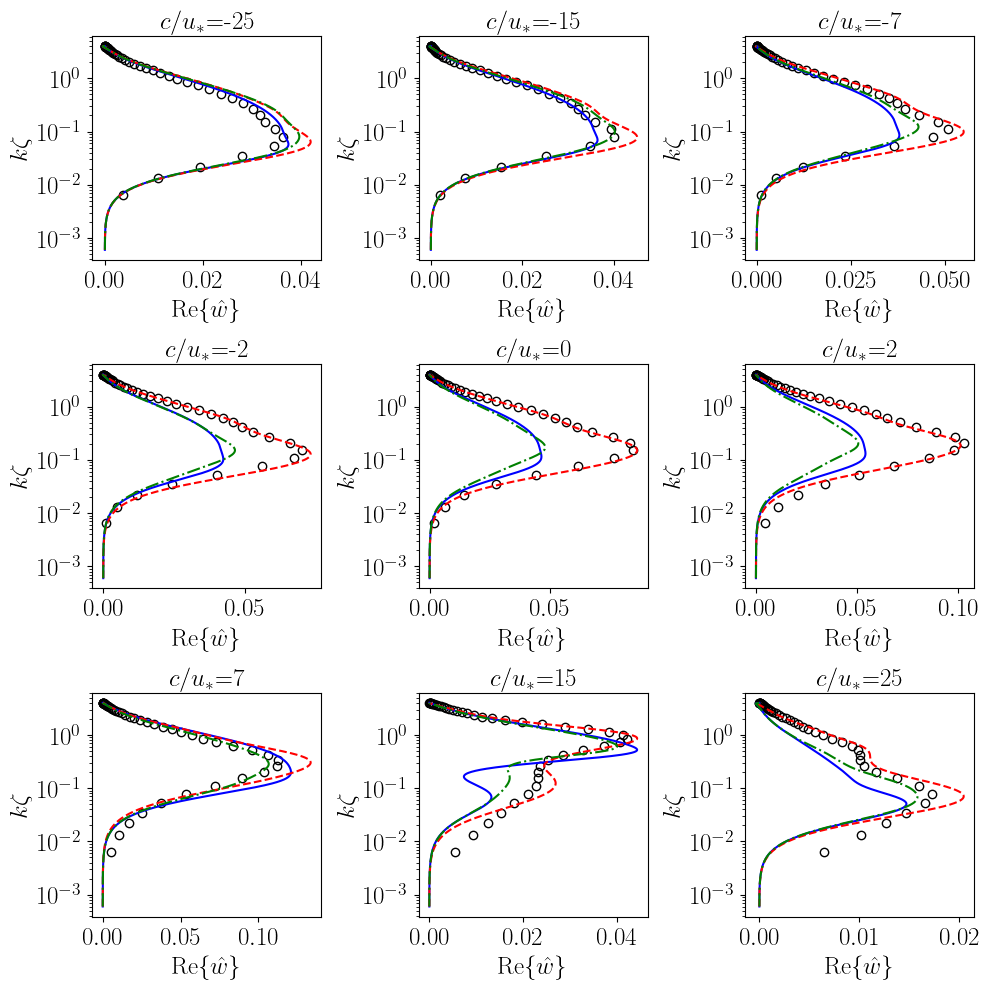

In [66]:
plt.figure(11,figsize=(10,10))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    w_LES_data = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    plt.semilogy(w_LES_data[16,::3].real,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none',label='$\Re\{\hat{w}\}$ (LES)')
    
    for n in range(3):
        plt.semilogy(Rew[:,n,num_data_select].real,k_wavno*z,color_array_plot_Im[n],label='$\Re\{\hat{w}\}$ (Model)')
    
    
    
    ax1.set_xlabel(r'Re$\{\hat{w}\}$',fontsize=18)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=18)
    ax1.set_ylabel(r'$k\zeta$',fontsize=18)
    ax1.tick_params(labelsize=18)

plt.savefig('Rew_profile_WRLES_vs_exp5_decay_Model_nuT_LES.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()


In [ ]:
plt.figure(11,figsize=(10,10))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    u_LES_data = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    plt.semilogy(u_LES_data[16,::2].imag,k_wavno*LES_data[num_data_select].zw[::2],'ko',markerfacecolor='none',label='$\Im\{\hat{w}\}$ (LES)')
    #plt.semilogy(w_LES_data[16,:].real,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none',label='$\Im\{\hat{w}\}$ (LES)')

    
    for n in range(3):
        plt.semilogy(Imu[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n],label='$\Im\{\hat{w}\}$ (Model)')
        #plt.semilogy(Rew[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n],label='$\Im\{\hat{w}\}$ (Model)')
    
    
    
    ax1.set_xlabel(r'Im$\{\hat{u}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
plt.show()   
#plt.savefig('Imu_profile_WRLES_vs_Model.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)

In [ ]:
plt.figure(11,figsize=(10,10))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    u_LES_data = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    plt.semilogy(u_LES_data[16,::3].real,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none',label='$\Im\{\hat{w}\}$ (LES)')
    #plt.semilogy(w_LES_data[16,:].real,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none',label='$\Im\{\hat{w}\}$ (LES)')

    
    for n in range(3):
        plt.semilogy(Reu[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n],label='$\Im\{\hat{w}\}$ (Model)')
        #plt.semilogy(Rew[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n],label='$\Im\{\hat{w}\}$ (Model)')
    
    
    
    ax1.set_xlabel(r'Re$\{\hat{u}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
plt.show()  
#plt.savefig('Reu_profile_WRLES_vs_Model.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)

In [ ]:
plt.figure(11,figsize=(10,10))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    p_LES_data = np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    #plt.semilogy(p_LES_data[16,:].real,k*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    plt.semilogy(p_LES_data[16,::3].imag,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none')
   
    for n in range(3):
        plt.semilogy(Imp[:,3,n,num_data_select],k_wavno*z,color_array_plot_Im[n])
        
    #plt.semilogy(np.abs(p_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{p}|$ (LES)')
    ax1.set_xlabel(r'Im$\{\hat{p}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)

plt.show()
#plt.savefig('Imp_profile_WRLES_vs_Model.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)



In [ ]:
plt.figure(11,figsize=(10,10))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    p_LES_data = np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    #plt.semilogy(p_LES_data[16,:].real,k*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    plt.semilogy(p_LES_data[16,::3].real,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none')

    for n in range(3):
        plt.semilogy(Rep[:,3,n,num_data_select].real,k_wavno*z,color_array_plot_Im[n])
        
    #plt.semilogy(np.abs(p_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{p}|$ (LES)')
    ax1.set_xlabel(r'Re$\{\hat{p}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
plt.show()
#plt.savefig('Rep_profile_WRLES_vs_Model.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)


\begin{align*}
F_p=\frac{1}{\lambda}\int_{0}^{\lambda}\frac{\widetilde{p}}{\rho_a u_\tau^2}\frac{d\widetilde{\eta}}{dx} \ dx
\end{align*}

In [106]:
Fp=np.zeros((9,4),dtype='float')
detadx=-a*k_wavno*np.sin(k_wavno*x_LES)
for num_data_select in range(9):
    phase_diff=0
    p_induced_visc = 2*Rep[0,3,0,num_data_select]*np.cos(k_wavno*x_LES+phase_diff)*1-1*2*Imp[0,3,0,num_data_select]*np.sin(k_wavno*x_LES+phase_diff)
    p_induced = 2*Rep[0,3,1,num_data_select]*np.cos(k_wavno*x_LES+phase_diff)*1-1*2*Imp[0,3,1,num_data_select]*np.sin(k_wavno*x_LES+phase_diff)
    p_induced_nuT = 2*Rep[0,3,2,num_data_select]*np.cos(k_wavno*x_LES+phase_diff)*1-1*2*Imp[0,3,2,num_data_select]*np.sin(k_wavno*x_LES+phase_diff)
    
    Fp[num_data_select,1]=(1/wavelength)*np.trapz(p_induced[0:55]*detadx[0:55],x_LES[0:55])#Turb Curv with interpolated stress
    Fp[num_data_select,2]=(1/wavelength)*np.trapz(p_induced_visc[0:55]*detadx[0:55],x_LES[0:55])#Visc Curv
    Fp[num_data_select,3]=(1/wavelength)*np.trapz(p_induced_nuT[0:55]*detadx[0:55],x_LES[0:55])#Turb Curv with modeled stress
    Fp[num_data_select,0]=(1/wavelength)*np.trapz(LES_data[num_data_select].p_w_surf[0:55]*detadx[0:55],x_LES[0:55])#LES

/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_61790/1039919473.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  Fp[num_data_select,1]=(1/wavelength)*np.trapz(p_induced[0:55]*detadx[0:55],x_LES[0:55])#Turb Curv with interpolated stress
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_61790/1039919473.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  Fp[num_data_select,2]=(1/wavelength)*np.trapz(p_induced_visc[0:55]*detadx[0:55],x_LES[0:55])#Visc Curv
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_61790/1039919473.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  Fp[num_data_select,3]=(1/wavelength)*np.trapz(p_induced_nuT[0:55]*detadx[0:55],x_LES[0:55])#Turb Curv with modeled stress


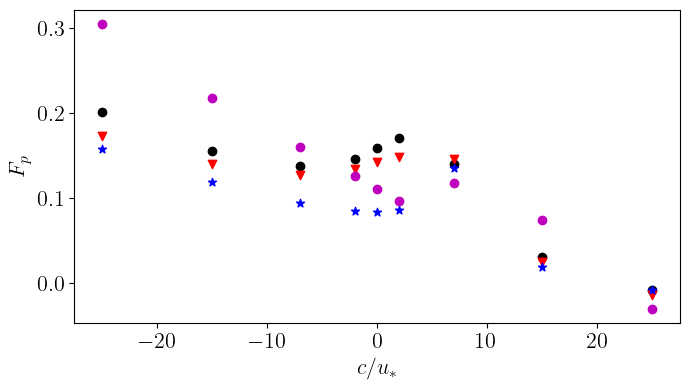

In [108]:
plt.figure(11,figsize=(7,4))
ax1=plt.subplot(1,1,1)

plt.scatter(c_array,Fp[:,0],color='k',label='LES')
plt.scatter(c_array,Fp[:,1],color='r',marker='v',label='Turb. Curv. Model ($\\tau_{ij}$ from LES)')
plt.scatter(c_array,Fp[:,2],color='b',marker='*',label='Visc. Curv. Model')
plt.scatter(c_array,Fp[:,3],color='m',marker='o',label='Turb. Curv. Model ($\\tau_{ij}=-2\\nu_T S_{ij}$)')

#plt.legend(frameon=False,fontsize=15)
ax1.set_xlabel(r'$c/u_*$',fontsize=16)
#ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
ax1.set_ylabel(r'$F_p$',fontsize=16)
ax1.tick_params(labelsize=16)

# ax1=plt.subplot(2,1,2)
# num_data_select=0;
# plt.plot(x_LES,LES_data[num_data_select].p_w_surf-np.mean(LES_data[num_data_select].p_w_surf),'k',label='LES')
# plt.plot(x_LES,2*Rep[0,3,0,num_data_select]*np.cos(k_wavno*x_LES)*1-1*2*Imp[0,3,0,num_data_select]*np.sin(k_wavno*x_LES+phase_diff),'m',label='Visc. Curv. Model')
# plt.plot(x_LES,2*Rep[0,3,1,num_data_select]*np.cos(k_wavno*x_LES)*1-1*2*Imp[0,3,1,num_data_select]*np.sin(k_wavno*x_LES+phase_diff),'b--',label='Turb. Curv. Model')
# #plt.legend()

plt.savefig('form_drag_no_exp_decay.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()  

In [109]:
mape_Turb_Curv_1=mape(Fp[:,0], Fp[:,1])
mape_Turb_Curv_2=mape(Fp[:,0], Fp[:,3])
mape_Visc_Curv=mape(Fp[:,0], Fp[:,2])
print(mape_Turb_Curv_1,mape_Turb_Curv_2,mape_Visc_Curv)

18.615463042014216 71.3681132179945 28.616783203408314
